'/n02dat01/users/dyli/Grad_data/sc/voxel_contribution/voxel_contribution_new_G{gg+1}.nii.gz'

In [1]:
import os
import gc
import sys
import time
import h5py
import torch
import numpy as np
import pandas as pd
from numpy.lib.function_base import corrcoef
import nibabel as nib
from nilearn import image, surface, plotting, datasets

from sklearn.metrics import pairwise_distances
import scipy.sparse as sps
import scipy as sp
from scipy.sparse.linalg import eigsh, eigs
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr

from matplotlib import font_manager
font_manager.fontManager.addfont("/n02dat01/users/lchai/anaconda3/envs/Nm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams["font.sans-serif"] = "Arial" 

/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# fiber infomation

In [2]:
fiber_label = np.array([
              1,1,2,2,3,3,3,3,3,3,3,
              3,1,1,4,4,1,1,4,4,
              3,4,4,1,1,1,1,4,1,1,
              1,1,4,4,1,1,1,1,1,1,
              2,2,1,1,3,2,2,2,2,2,
              2,2,2,2,2,2,2,5,5,5,
              5,5,5,5,5,5,5,5,5,5,
              5])
fiber_label = fiber_label-1
print(len(fiber_label))

71


In [3]:
l_idx = [1,3,13,15,17,19,22,24,26,29,31,33,35,37,39,41,43,46,48,50,52,54,56,58,60,62,64,66,68,70]
r_idx = [2,4,14,16,18,20,23,25,27,30,32,34,36,38,40,42,44,47,49,51,53,55,57,59,61,63,65,67,69,71]
m_idx = [4,5,6,7,8,9,10,11,20,28,45]
l_idx = np.array(l_idx)
r_idx = np.array(r_idx)
m_idx = np.array(m_idx)
l_idx = l_idx-1
r_idx = r_idx-1
print(len(l_idx), len(r_idx), len(m_idx))

30 30 11


In [4]:
# 读取纤维束名字
# label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_nonum_nohemi_new.txt', 'r')
label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_nonum.txt', 'r')
label_name = label_f.readlines()
label_name = [' '.join([i.strip() for i in price.strip().split('\n')]) for price in label_name]
print(len(label_name))

fiber_label_colormap = ['#E07A5f', '#B58DB6', '#3D405B', '#81B29A', '#F2CC8F']

72


In [5]:
dirc_L = f'/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = f'/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# mean Fingerprint

In [ ]:
x = np.random.rand(10,3)
print(np.sum(x, axis=0))

[6.4150831  3.45803727 4.51593685]


In [ ]:
list_path = f'/n02dat01/users/dyli/Grad_data/support_data/HCP_U100_list.txt'
# list_path = './HCP_218.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(len(namelist))

def normalization_fiber(x):
    return x/np.sum(x, axis=0)

fp_l = np.zeros((29696, 72))
fp_r = np.zeros((29716, 72))
nan_num_l = 0
nan_num_r = 0
for sub in tqdm(namelist):
    if os.path.exists(f'/n04dat01/atlas_group/lma/HCP_S1200_individual_MSM_atlas/{sub}/{sub}_L_probtrackx_omatrix2/finger_print_fiber_MSMALL.npz'):
        if ~np.isnan(normalization_fiber(sps.load_npz(f'/n04dat01/atlas_group/lma/HCP_S1200_individual_MSM_atlas/{sub}/{sub}_L_probtrackx_omatrix2/finger_print_fiber_MSMALL.npz').toarray())).any():
            fp_l = fp_l + normalization_fiber(sps.load_npz(f'/n04dat01/atlas_group/lma/HCP_S1200_individual_MSM_atlas/{sub}/{sub}_L_probtrackx_omatrix2/finger_print_fiber_MSMALL.npz').toarray())
        else:
            nan_num_l +=1
    else:
        if ~np.isnan(normalization_fiber(sps.load_npz(f'/n04dat01/atlas_group/lma/HCP_S1200_individual_MSM_atlas/{sub}/{sub}_L_probtrackx_omatrix2/finger_print_fiber.npz').toarray())).any():
            fp_l = fp_l + normalization_fiber(sps.load_npz(f'/n04dat01/atlas_group/lma/HCP_S1200_individual_MSM_atlas/{sub}/{sub}_L_probtrackx_omatrix2/finger_print_fiber.npz').toarray())
        else:
            nan_num_l +=1

    if os.path.exists(f'/n04dat01/atlas_group/lma/HCP_S1200_individual_MSM_atlas/{sub}/{sub}_R_probtrackx_omatrix2/finger_print_fiber_MSMALL.npz'):
        if ~np.isnan(normalization_fiber(sps.load_npz(f'/n04dat01/atlas_group/lma/HCP_S1200_individual_MSM_atlas/{sub}/{sub}_R_probtrackx_omatrix2/finger_print_fiber_MSMALL.npz').toarray())).any():
            fp_r = fp_r + normalization_fiber(sps.load_npz(f'/n04dat01/atlas_group/lma/HCP_S1200_individual_MSM_atlas/{sub}/{sub}_R_probtrackx_omatrix2/finger_print_fiber_MSMALL.npz').toarray())
        else:
            nan_num_r +=1
    else:
        if ~np.isnan(normalization_fiber(sps.load_npz(f'/n04dat01/atlas_group/lma/HCP_S1200_individual_MSM_atlas/{sub}/{sub}_R_probtrackx_omatrix2/finger_print_fiber.npz').toarray())).any():
            fp_r = fp_r + normalization_fiber(sps.load_npz(f'/n04dat01/atlas_group/lma/HCP_S1200_individual_MSM_atlas/{sub}/{sub}_R_probtrackx_omatrix2/finger_print_fiber.npz').toarray())
        else:
            nan_num_r +=1
        
np.save('/n02dat01/users/dyli/Grad_data/sc/FP_U100_mean_L.npy', fp_l/(100-nan_num_l))
np.save('/n02dat01/users/dyli/Grad_data/sc/FP_U100_mean_R.npy', fp_r/(100-nan_num_r))

100


 48%|████▊     | 48/100 [00:22<00:23,  2.18it/s]/tmp/ipykernel_105258/821831574.py:8: RuntimeWarning: invalid value encountered in true_divide
  return x/np.sum(x, axis=0)
100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


In [ ]:
print(nan_num_l, nan_num_r)

1 0


In [ ]:
assert ~np.isnan(fp_l).any()
assert ~np.isnan(fp_r).any()

# fiber contri

In [6]:
emb_L = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_L_zeros.npy')
emb_R = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_R_zeros.npy')

fp_l = np.load('/n02dat01/users/dyli/Grad_data/sc/FP_U100_mean_L.npy')
fp_r = np.load('/n02dat01/users/dyli/Grad_data/sc/FP_U100_mean_R.npy')

In [7]:
fiber_contri_mean = np.zeros((72, 3))
fiber_contri_var  = np.zeros((72, 3))
fiber_contri_cha  = np.zeros((72, 3))

def saveSurf( template, data, path, save_name ):
    template.remove_gifti_data_array(0)
    template.add_gifti_data_array( nib.gifti.gifti.GiftiDataArray( np.array( data, np.float32 )))
    nib.loadsave.save( template, os.path.join( path, save_name ))

# 读取纤维束名字
# label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_nonum_nohemi_new.txt', 'r')
label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_nonum.txt', 'r')
label_name = label_f.readlines()
label_name = [' '.join([i.strip() for i in price.strip().split('\n')]) for price in label_name]

pipeline_path = './'
for gg in range(3):
    GC = emb_L[:, gg]
    for fi in range(72):
        fp_l_fiber = fp_l[:, fi] # (29696,)
        # contri_l_fiber = fp_l_fiber * GC
        idx = np.argwhere(fp_l_fiber>np.max(fp_l_fiber)*0.5)
        contri_l_fiber = GC[idx]
        fiber_contri_mean[fi, gg] = np.mean(contri_l_fiber)
        fiber_contri_var[fi, gg] = np.std(contri_l_fiber)
        fiber_contri_cha[fi, gg] = np.max(contri_l_fiber) - np.min(contri_l_fiber)

In [8]:
fiber_contri_mean = np.zeros((72, 3))
fiber_contri_var  = np.zeros((72, 3))
fiber_contri_cha  = np.zeros((72, 3))

# 读取纤维束名字
# label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_nonum_nohemi_new.txt', 'r')
label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_nonum.txt', 'r')
label_name = label_f.readlines()
label_name = [' '.join([i.strip() for i in price.strip().split('\n')]) for price in label_name]

pipeline_path = './'
for gg in range(3):
    GC = emb_L[:, gg]
    for fi in range(72):
        fp_l_fiber = fp_l[:, fi] # (29696,)
        # contri_l_fiber = fp_l_fiber * GC
        idx = np.argwhere(fp_l_fiber>np.max(fp_l_fiber)*0.5)
        contri_l_fiber = GC[idx]
        fiber_contri_mean[fi, gg] = np.mean(contri_l_fiber)
        fiber_contri_var[fi, gg] = np.std(contri_l_fiber)
        fiber_contri_cha[fi, gg] = np.max(contri_l_fiber) - np.min(contri_l_fiber)

In [21]:
fiber_numpy = np.concatenate((fiber_contri_mean, fiber_contri_var), axis=1)
print(fiber_numpy.shape)
fiber_numpy = np.concatenate((fiber_numpy, fiber_contri_cha), axis=1)
print(fiber_numpy.shape)
fiber_numpy1 = fiber_numpy.copy()
fiber_numpy1[:, 1] = fiber_numpy[:, 3]
fiber_numpy1[:, 2] = fiber_numpy[:, 6]
fiber_numpy1[:, 3] = fiber_numpy[:, 1]
fiber_numpy1[:, 4] = fiber_numpy[:, 4]
fiber_numpy1[:, 5] = fiber_numpy[:, 7]
fiber_numpy1[:, 6] = fiber_numpy[:, 2]
fiber_numpy1[:, 7] = fiber_numpy[:, 5]
fiber_numpy1[:, 8] = fiber_numpy[:, 8]

df = pd.DataFrame(fiber_numpy1, index=label_name, columns=['GC1 mean', 'GC1 var', 'GC1 diff','GC2 mean', 'GC2 var', 'GC2 diff','GC3 mean', 'GC3 var', 'GC3 diff'])
df.to_csv('/n02dat01/users/dyli/Grad_data/voxel_contribution_correlation/fiber_contri_byr2/fiber_contri.csv')

(72, 6)
(72, 9)


In [ ]:
fiber_index_wewant = [0,10,12,15,16,17,18,19,20,21,23]

In [27]:
df = pd.read_csv('/n02dat01/users/dyli/Grad_data/voxel_contribution_correlation/fiber_contri_byr2/fiber_contri_new.csv')
df

Unnamed: 0  GC1 mean  GC1 var  GC1 diff  GC2 mean  GC2 var  GC2 diff  \
0          AF    -1.067    7.195    34.021     0.520    6.147    22.530   
1         ATR     0.689    3.927    16.154   -12.049    3.870    13.526   
2          CA   -12.761    1.340     6.881     0.191    1.482     5.755   
3        CC_1    -5.543    1.945     8.045   -10.673    1.550     6.553   
4        CC_2     4.538    5.766    27.474   -11.125    4.613    19.250   
5        CC_3     8.165    2.914    12.328    -6.537    3.833    15.103   
6        CC_4    16.903    2.059     9.609     2.023    2.265     9.772   
7        CC_5    15.712    2.756    12.198     3.603    3.364    13.850   
8        CC_6    -0.475    7.935    32.863     4.152    3.197    17.399   
9        CC_7   -15.888    1.332     7.910     2.902    0.658     4.756   
10         CG     0.867    3.320    23.597    -9.510    2.209    14.534   
11        CST    17.603    1.835     9.296     3.698    2.349     9.647   
12        MLF    -2.890    5.145    25.997     5.132    1.550    12.235   
13        FPT     8.854    5.700    21.179    -8.911    6.032    19.989   
14         FX   -17.982    0.438     2.437     1.816    0.327     1.722   
15        IFO    -8.793    4.860    17.063    -0.629    3.308    11.634   
16        ILF   -14.162    2.731    10.437     2.592    1.242     7.789   
17         OR   -14.879    1.852    11.730     3.098    0.945     4.140   
18       POPT     8.616   10.518    36.077     5.482    1.818     9.206   
19      SLF_I    10.018    4.998    25.418     0.368    6.567    24.240   
20     SLF_II     4.739    6.609    27.575    -2.191    8.787    25.231   
21    SLF_III     5.461    4.431    18.017     1.283    6.138    20.547   
22        STR    16.910    1.486     6.744     3.510    1.562     6.844   
23         UF   -10.446    1.283     5.591    -1.980    1.603     8.708   
24     T_PREF     4.356    5.984    27.942   -10.861    4.899    19.216   
25     T_PREM     6.800    3.703    16.291    -7.020    3.784    15.275   
26     T_PREC    16.932    2.562    11.970     3.195    2.820    11.089   
27    T_POSTC    17.098    1.814     9.465     6.369    1.275     6.290   
28      T_PAR     6.439    9.808    36.276     5.612    2.293    13.754   
29      T_OCC   -14.883    1.851    12.056     3.096    0.973     4.182   
30      ST_FO    -7.399    2.637    11.749    -6.811    2.545    10.777   
31    ST_PREF     3.001    6.669    31.067   -10.135    5.092    19.852   
32    ST_PREM     6.614    3.674    15.976    -6.031    3.774    15.220   
33    ST_PREC    14.311    5.211    24.497     2.943    2.809    11.391   
34   ST_POSTC    14.986    4.827    24.497     5.873    1.522     7.983   
35     ST_PAR     4.017    8.717    32.757     5.519    1.818    10.206   
36     ST_OCC   -13.961    2.883    16.299     2.583    1.144     6.840   

    GC3 mean  GC3 var  GC3 diff  
0      5.846    2.282    10.644  
1      7.024    1.937     8.012  
2      0.335    1.218     5.971  
3     -4.625    2.844    10.943  
4      2.570    6.007    20.669  
5      5.371    2.435     8.817  
6     -2.707    3.246    14.137  
7     -5.820    2.438     9.732  
8     -0.517    5.853    19.680  
9     -2.593    1.448     6.338  
10    -9.501    4.161    18.056  
11    -2.339    2.546    11.811  
12     2.906    4.705    18.160  
13     2.161    3.830    13.638  
14    -5.174    0.790     2.955  
15     2.811    3.029     9.024  
16    -0.063    2.439     9.999  
17    -0.775    1.248     6.945  
18    -3.593    2.467    13.985  
19    -1.498    4.634    17.762  
20     3.619    3.762    12.334  
21     5.306    2.975    10.596  
22    -6.481    1.248     5.541  
23     1.265    1.340     5.940  
24     4.765    4.026    16.368  
25     6.331    2.209     8.513  
26    -1.672    3.026    13.564  
27    -2.956    2.350    12.207  
28    -2.353    3.543    17.079  
29    -0.796    1.251     7.292  
30     1.792    3.379    15.028  
31     4.245    4.273    18.397  
32     6.353    2.134     8.55

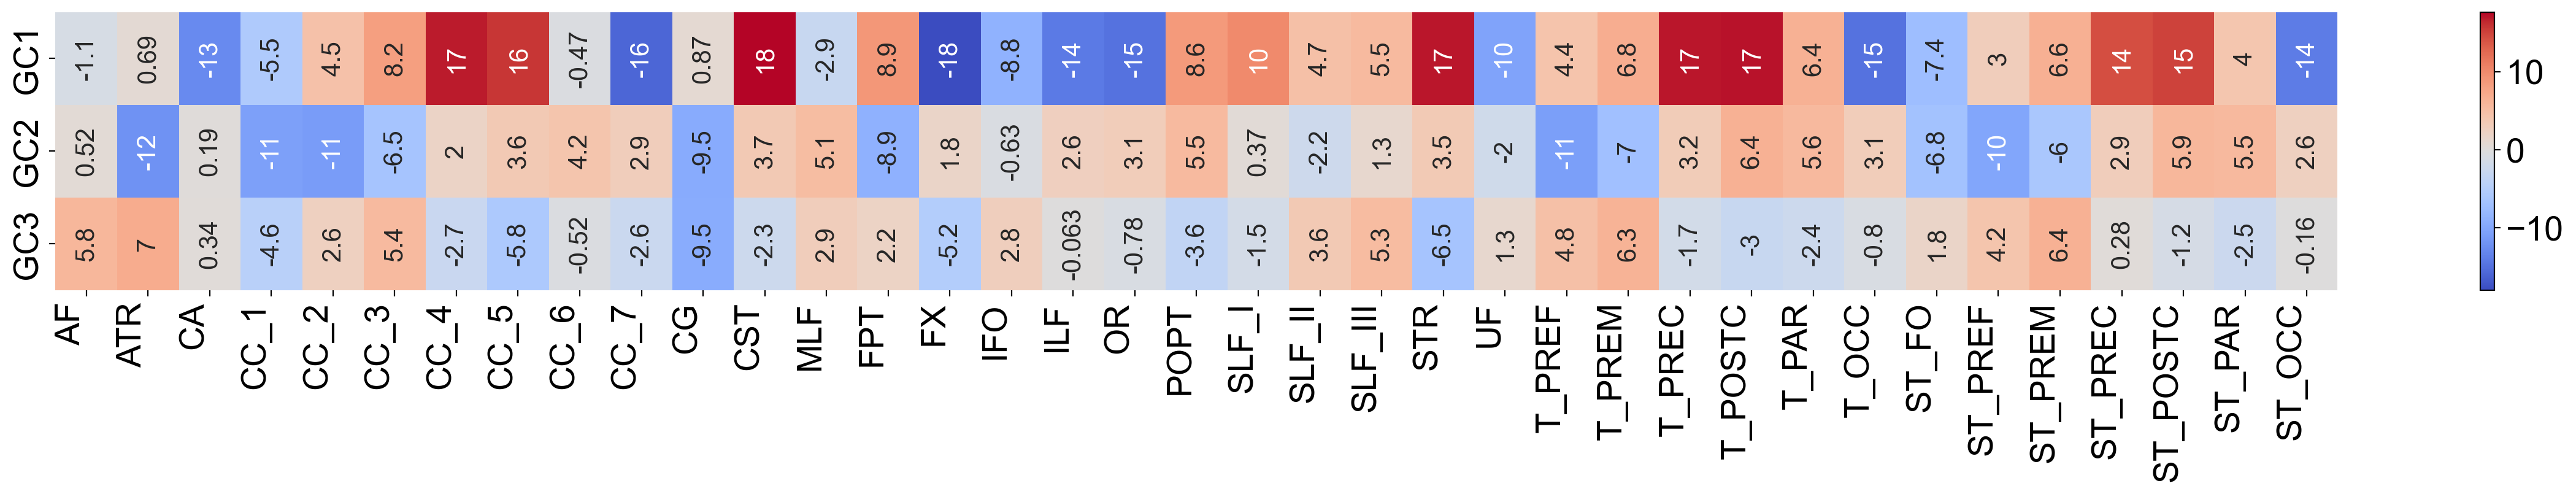

In [52]:
# plot the mean and var for contri
colume_name = ['GC1', 'GC2', 'GC3']
f, ax= plt.subplots(figsize = (30, 3), dpi=200)
x = np.zeros((37,3))
x[:,0] = df.values[:,1]
x[:,1] = df.values[:,4]
x[:,2] = df.values[:,7]
corr_df = pd.DataFrame(x.T, columns=list(np.squeeze(df[['Unnamed: 0']].values)), index=colume_name)
fig = sns.heatmap(corr_df, 
                  cmap='coolwarm', 
                  cbar=False,
                  annot=True, 
                  annot_kws={'size':15, 'rotation':90})
cb = fig.figure.colorbar(fig.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=20) #设置colorbar刻度字体大小
ax.tick_params(labelsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha = 'right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha = 'right')
fig = fig.get_figure()
fig.show()


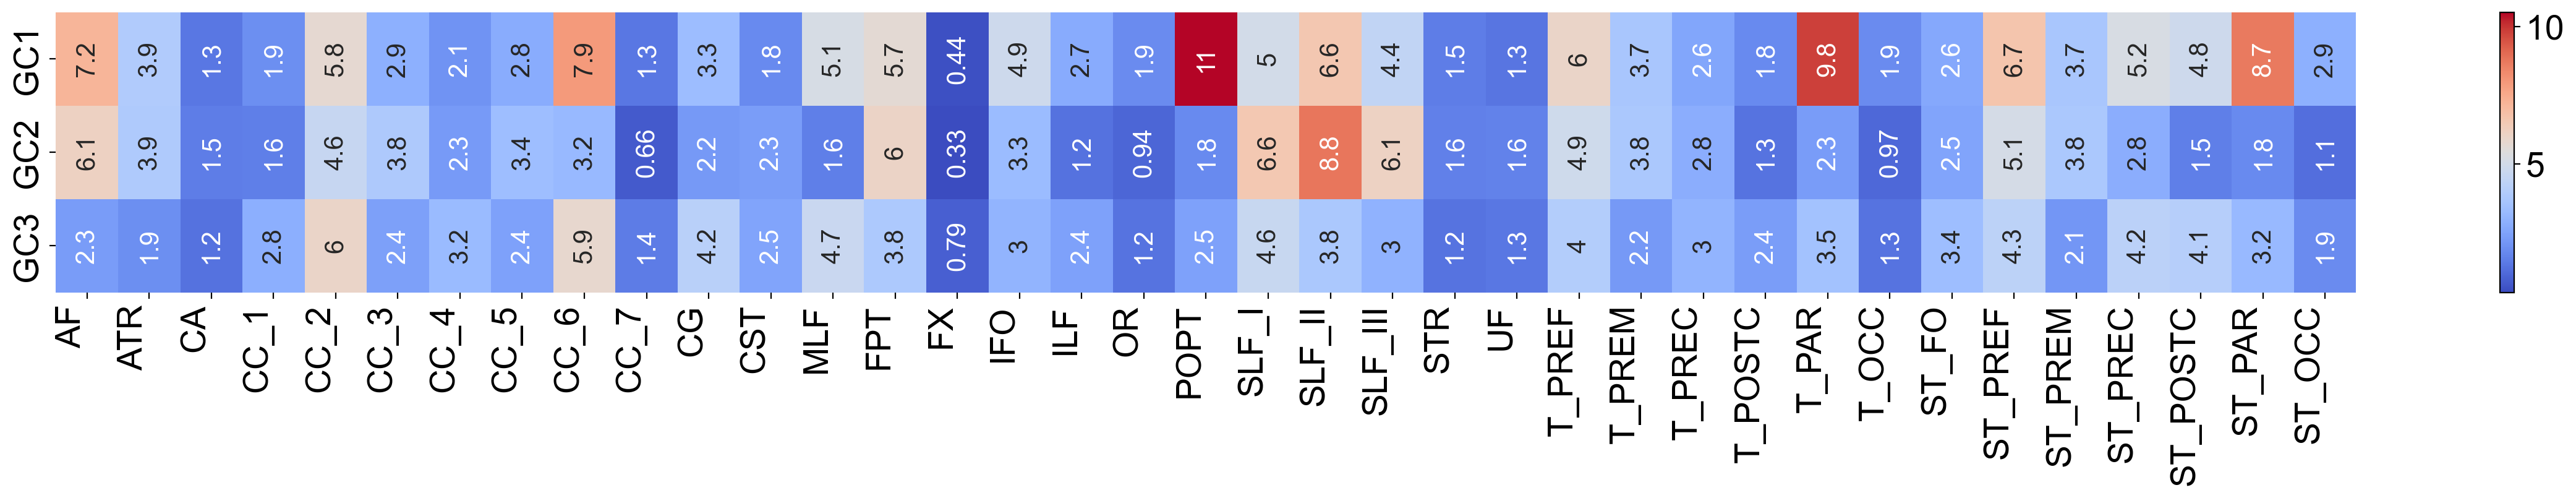

In [53]:
# plot the mean and var for contri
colume_name = ['GC1', 'GC2', 'GC3']
f, ax= plt.subplots(figsize = (30, 3), dpi=200)
x = np.zeros((37,3))
x[:,0] = df.values[:,2]
x[:,1] = df.values[:,5]
x[:,2] = df.values[:,8]
corr_df = pd.DataFrame(x.T, columns=list(np.squeeze(df[['Unnamed: 0']].values)), index=colume_name)
fig = sns.heatmap(corr_df, 
                  cmap='coolwarm', 
                  cbar=False,
                  annot=True, 
                  annot_kws={'size':15, 'rotation':90})
cb = fig.figure.colorbar(fig.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=20) #设置colorbar刻度字体大小
ax.tick_params(labelsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha = 'right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha = 'right')
fig = fig.get_figure()
fig.show()


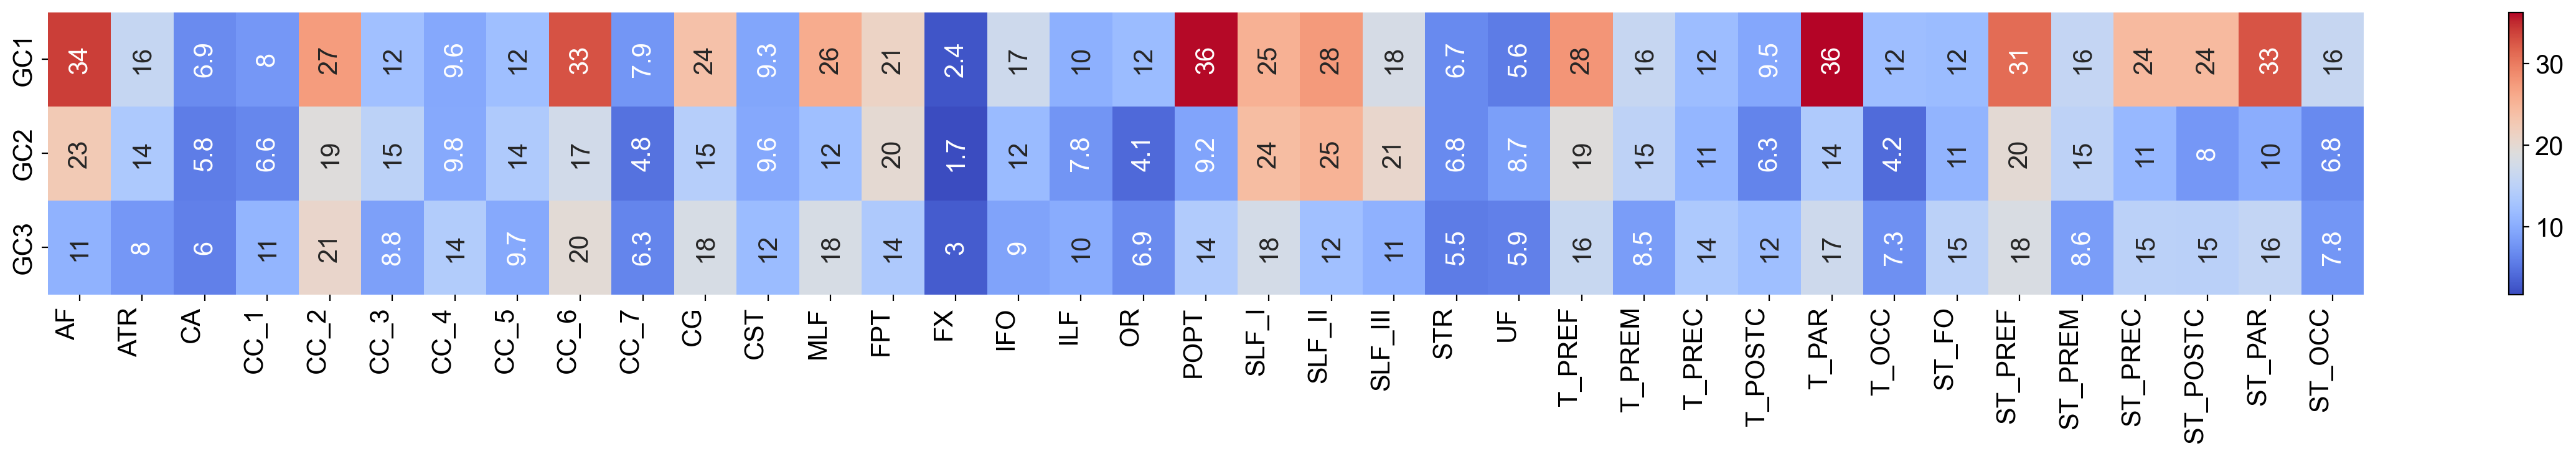

In [51]:
# plot the mean and var for contri
colume_name = ['GC1', 'GC2', 'GC3']
f, ax= plt.subplots(figsize = (30, 3), dpi=200)
x = np.zeros((37,3))
x[:,0] = df.values[:,3]
x[:,1] = df.values[:,6]
x[:,2] = df.values[:,9]
corr_df = pd.DataFrame(x.T, columns=list(np.squeeze(df[['Unnamed: 0']].values)), index=colume_name)
fig = sns.heatmap(corr_df, 
                  cmap='coolwarm', 
                  cbar=False,
                  annot=True, 
                  annot_kws={'size':15, 'rotation':90})
cb = fig.figure.colorbar(fig.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=15) #设置colorbar刻度字体大小
ax.tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha = 'right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha = 'right')
fig = fig.get_figure()
fig.show()


In [9]:
print(np.corrcoef(fiber_contri_cha[:, 0], fiber_contri_var[:, 0])[0,1])
print(np.corrcoef(fiber_contri_cha[:, 1], fiber_contri_var[:, 1])[0,1])
print(np.corrcoef(fiber_contri_cha[:, 2], fiber_contri_var[:, 2])[0,1])

0.9050679053363362
0.9445320081140384
0.9597049937136637


0.9567948742079764
0.9287293722749909
0.9841886605098317


/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

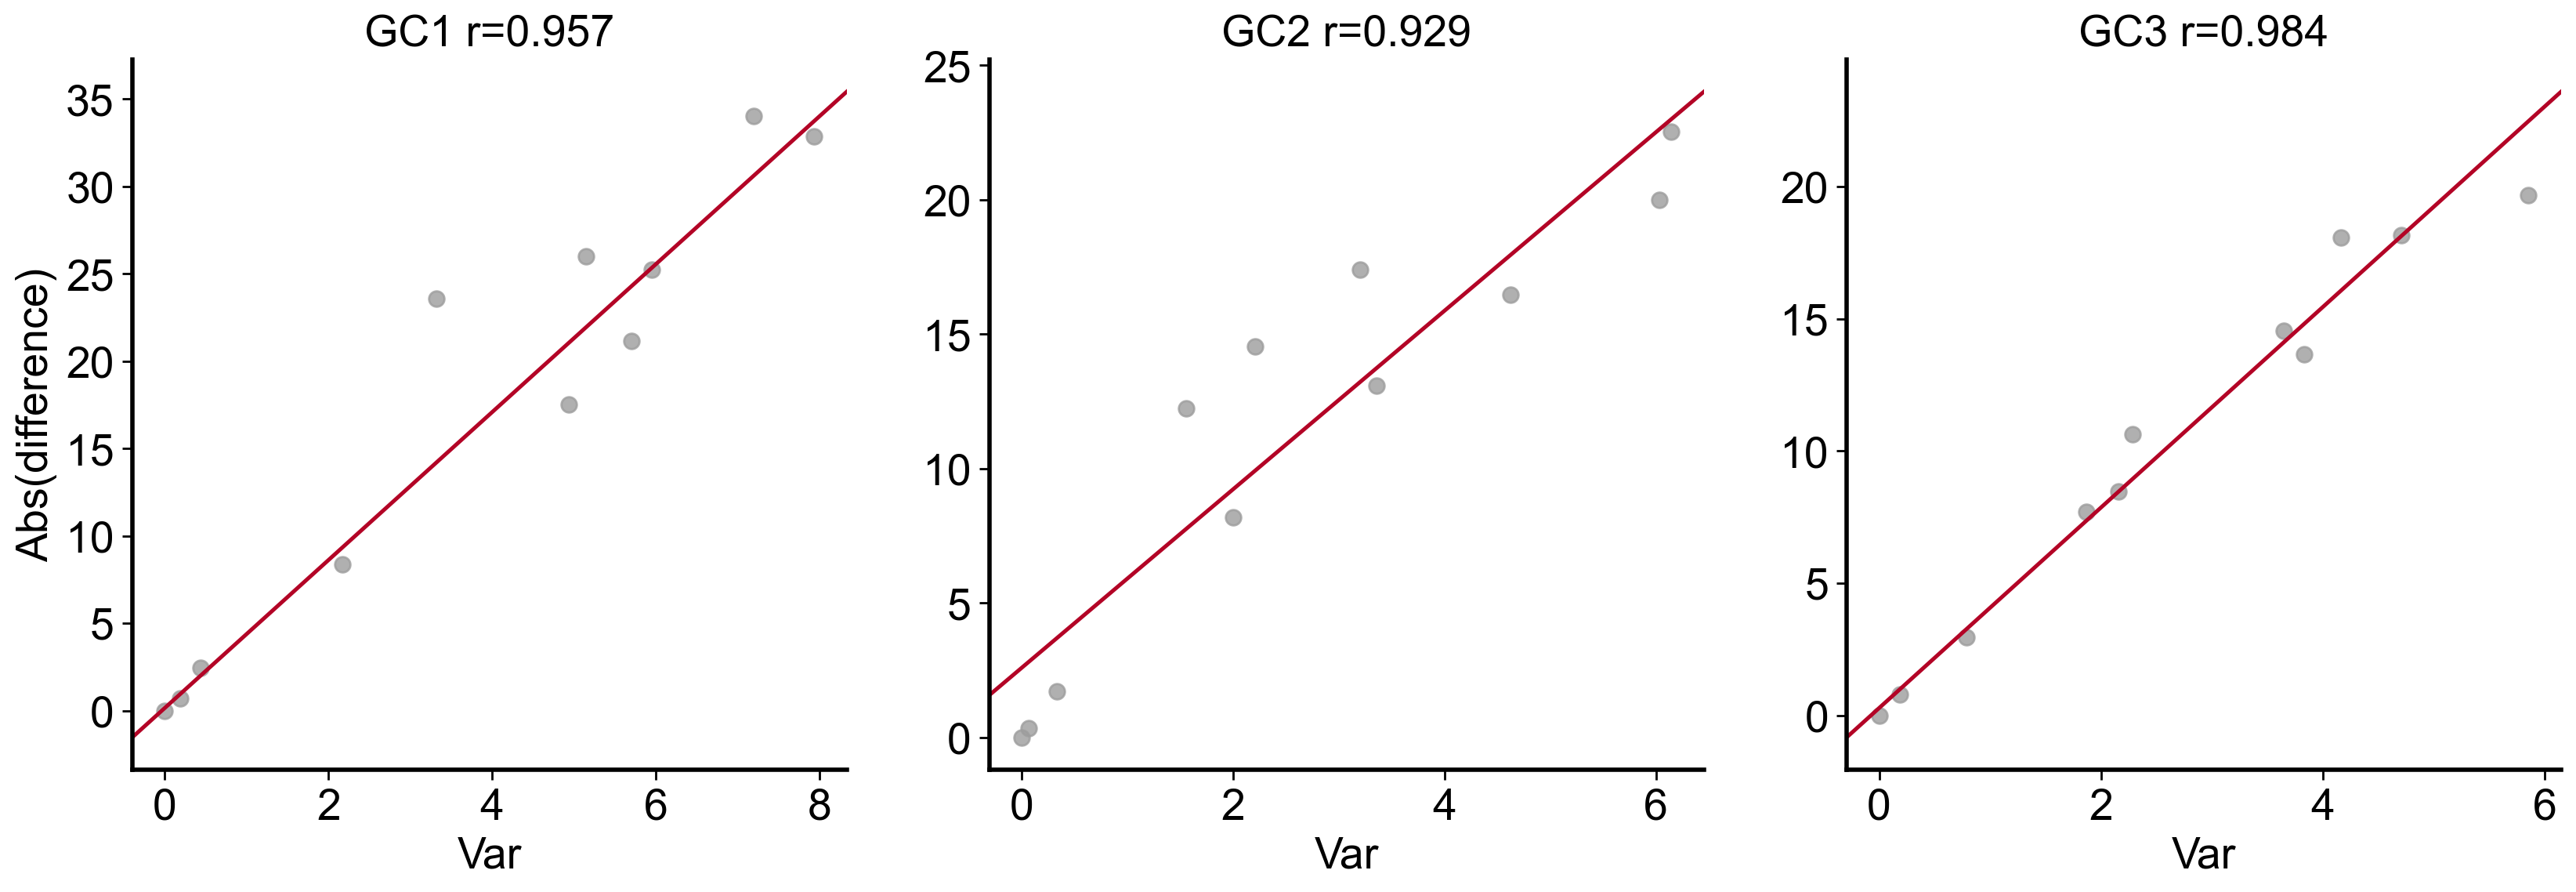

In [29]:
fig = plt.figure(figsize=(20, 6), dpi=200)
sns.set_context("paper", font_scale = 1.8)

# find the fiber index
fiber_idx_wewant = [0,10,12,15,16,17,18,19,20,21,23]

for gg in range(3):
    x = fiber_contri_var[fiber_idx_wewant, gg]
    y = fiber_contri_cha[fiber_idx_wewant, gg]
    if gg==0: ax1=fig.add_subplot(131)
    if gg==1: ax1=fig.add_subplot(132)
    if gg==2: ax1=fig.add_subplot(133)
    print(np.corrcoef(x,y)[0,1])
    fig = sns.regplot(x,y,
            ci=None,
            robust=True,
            scatter_kws={'s':50, 'color':'#9d9d9d'},
            line_kws={'linestyle':'solid', 'color':'#b30426'},
            marker='o', truncate=False,
            )
    ax1 = plt.gca()
    plt.yticks(fontsize=20) 
    plt.xticks(fontsize=20)
    plt.xlabel('Var', fontsize=20)
    if gg==0: plt.ylabel('Abs(difference)', fontsize=20)
    else: plt.ylabel('', fontsize=20)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_linewidth('2.0')
    ax1.spines['left'].set_linewidth('2.0')
    plt.title(f'GC{gg+1} r={np.round(np.corrcoef(x,y)[0,1],3)}', fontsize=20)
    fig = fig.get_figure()
plt.show()

# data for plotting

In [9]:
# 读取纤维束名字
label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_easy.txt', 'r')
label_name = label_f.readlines()
label_name = [' '.join([i.strip() for i in price.strip().split('\n')]) for price in label_name]

l_idx = [1,3,13,15,17,19,21,23,25,27,30,32,34,36,38,40,42,44,47,49,51,53,55,57,59,61,63,65,67,69,71]
r_idx = [2,4,14,16,18,20,22,24,26,28,31,33,35,37,39,41,43,45,48,50,52,54,56,58,60,62,64,66,68,70,72]
m_idx = [4,5,6,7,8,9,10,11,28,45]
l_idx = np.array(l_idx)
r_idx = np.array(r_idx)
m_idx = np.array(m_idx)
l_idx = l_idx-1
r_idx = r_idx-1
idx_change = np.array([1,3,13,15,17,19,21,23,25,27,30,32,34,36,38,40,42,44,47,49,51,53,55,57,59,61,63,65,67,69,71, 
                       2,4,14,16,18,20,22,24,26,28,31,33,35,37,39,41,43,45,48,50,52,54,56,58,60,62,64,66,68,70,72, 
                       5,6,7,8,9,10,11,12,29,46])
idx_change -=1

print(l_idx.shape, r_idx.shape, m_idx.shape)

fiber_contri_mean_change = np.zeros((72, 3))
fiber_contri_mean_change[0:31, :] = fiber_contri_mean[l_idx, :]
fiber_contri_mean_change[31:62, :] = fiber_contri_mean[r_idx, :]
fiber_contri_mean_change[62:72, :] = fiber_contri_mean[m_idx, :]
fiber_contri_var_change = np.zeros((72, 3))
fiber_contri_var_change[0:31, :] = fiber_contri_var[l_idx, :]
fiber_contri_var_change[31:62, :] = fiber_contri_var[r_idx, :]
fiber_contri_var_change[62:72, :] = fiber_contri_var[m_idx, :]

label_name_change = [label_name[idx_change[i]] for i in range(72)]

(31,) (31,) (10,)


In [10]:
from utils import Hex_to_RGB
import pandas as pd
import seaborn as sns

# 读取纤维束label
fiber_label = np.array([
              1,1,2,2,3,3,3,3,3,3,3,
              3,1,1,4,4,1,1,4,4,3,
              3,4,4,1,1,1,1,4,1,1,
              1,1,4,4,1,1,1,1,1,1,
              2,2,1,1,3,2,2,2,2,2,
              2,2,2,2,2,2,2,5,5,5,
              5,5,5,5,5,5,5,5,5,5,
              5])
fiber_label = fiber_label-1

# 读取纤维束名字
# label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_nonum_nohemi_new.txt', 'r')
label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_nonum.txt', 'r')
label_name = label_f.readlines()
label_name = [' '.join([i.strip() for i in price.strip().split('\n')]) for price in label_name]

# 读取纤维束mean和var
fiber_contri_mean_lm = np.zeros((41, 3))
fiber_contri_mean_lm[0:31] = fiber_contri_mean[l_idx]
fiber_contri_mean_lm[31:41] = fiber_contri_mean[m_idx]
fiber_contri_var_lm = np.zeros((41, 3))
fiber_contri_var_lm[0:31] = fiber_contri_var[l_idx]
fiber_contri_var_lm[31:41] = fiber_contri_var[m_idx]

fiber_label_lm = np.zeros(41)
fiber_label_lm[0:31] = fiber_label[l_idx]
fiber_label_lm[31:41] = fiber_label[m_idx]

label_name_lm = [label_name[l_idx[i]] for i in range(31)]
for i in range(10):
    label_name_lm.append(label_name[m_idx[i]])

# 对fiber进行排序
fiber_label_lm_idx = np.argsort(fiber_label_lm)
fiber_label_lm_change = fiber_label_lm[fiber_label_lm_idx]

label_name_lm_change = [label_name_lm[fiber_label_lm_idx[i]] for i in range(41)]

# 对每个纤维束标色
fiber_label_colormap = ['#E07A5f', '#B58DB6', '#3D405B', '#81B29A', '#F2CC8F']
fiber_label_rgb = np.zeros((5, 3))
for hex_i, hex in enumerate(fiber_label_colormap):
    fiber_label_rgb[hex_i, :] = Hex_to_RGB(hex)

fiber_lm_color_hex = [fiber_label_colormap[int(fiber_label_lm_change[i])] for i in range(41)]

fiber_lm_color_rgb = np.zeros((41, 3, 3))
for i in range(41):
    fiber_lm_color_rgb[i, 0, :] = fiber_label_rgb[int(fiber_label_lm_change[i]), :]
    fiber_lm_color_rgb[i, 1, :] = fiber_label_rgb[int(fiber_label_lm_change[i]), :]
    fiber_lm_color_rgb[i, 2, :] = fiber_label_rgb[int(fiber_label_lm_change[i]), :]
fiber_lm_color_rgb /= 255
fiber_lm_color_rgb = fiber_lm_color_rgb.astype(np.float32)

# 对纤维束的mean和var改变顺序
fiber_contri_mean_lm_change = fiber_contri_mean_lm[fiber_label_lm_idx]
fiber_contri_var_lm_change = fiber_contri_var_lm[fiber_label_lm_idx]
fiber_color_lm_change = fiber_lm_color_rgb[fiber_label_lm_idx, ...]

* remove 
* ICP 22 23
* SCP 33 34
* MCP 28
* CC 45

# France plotting

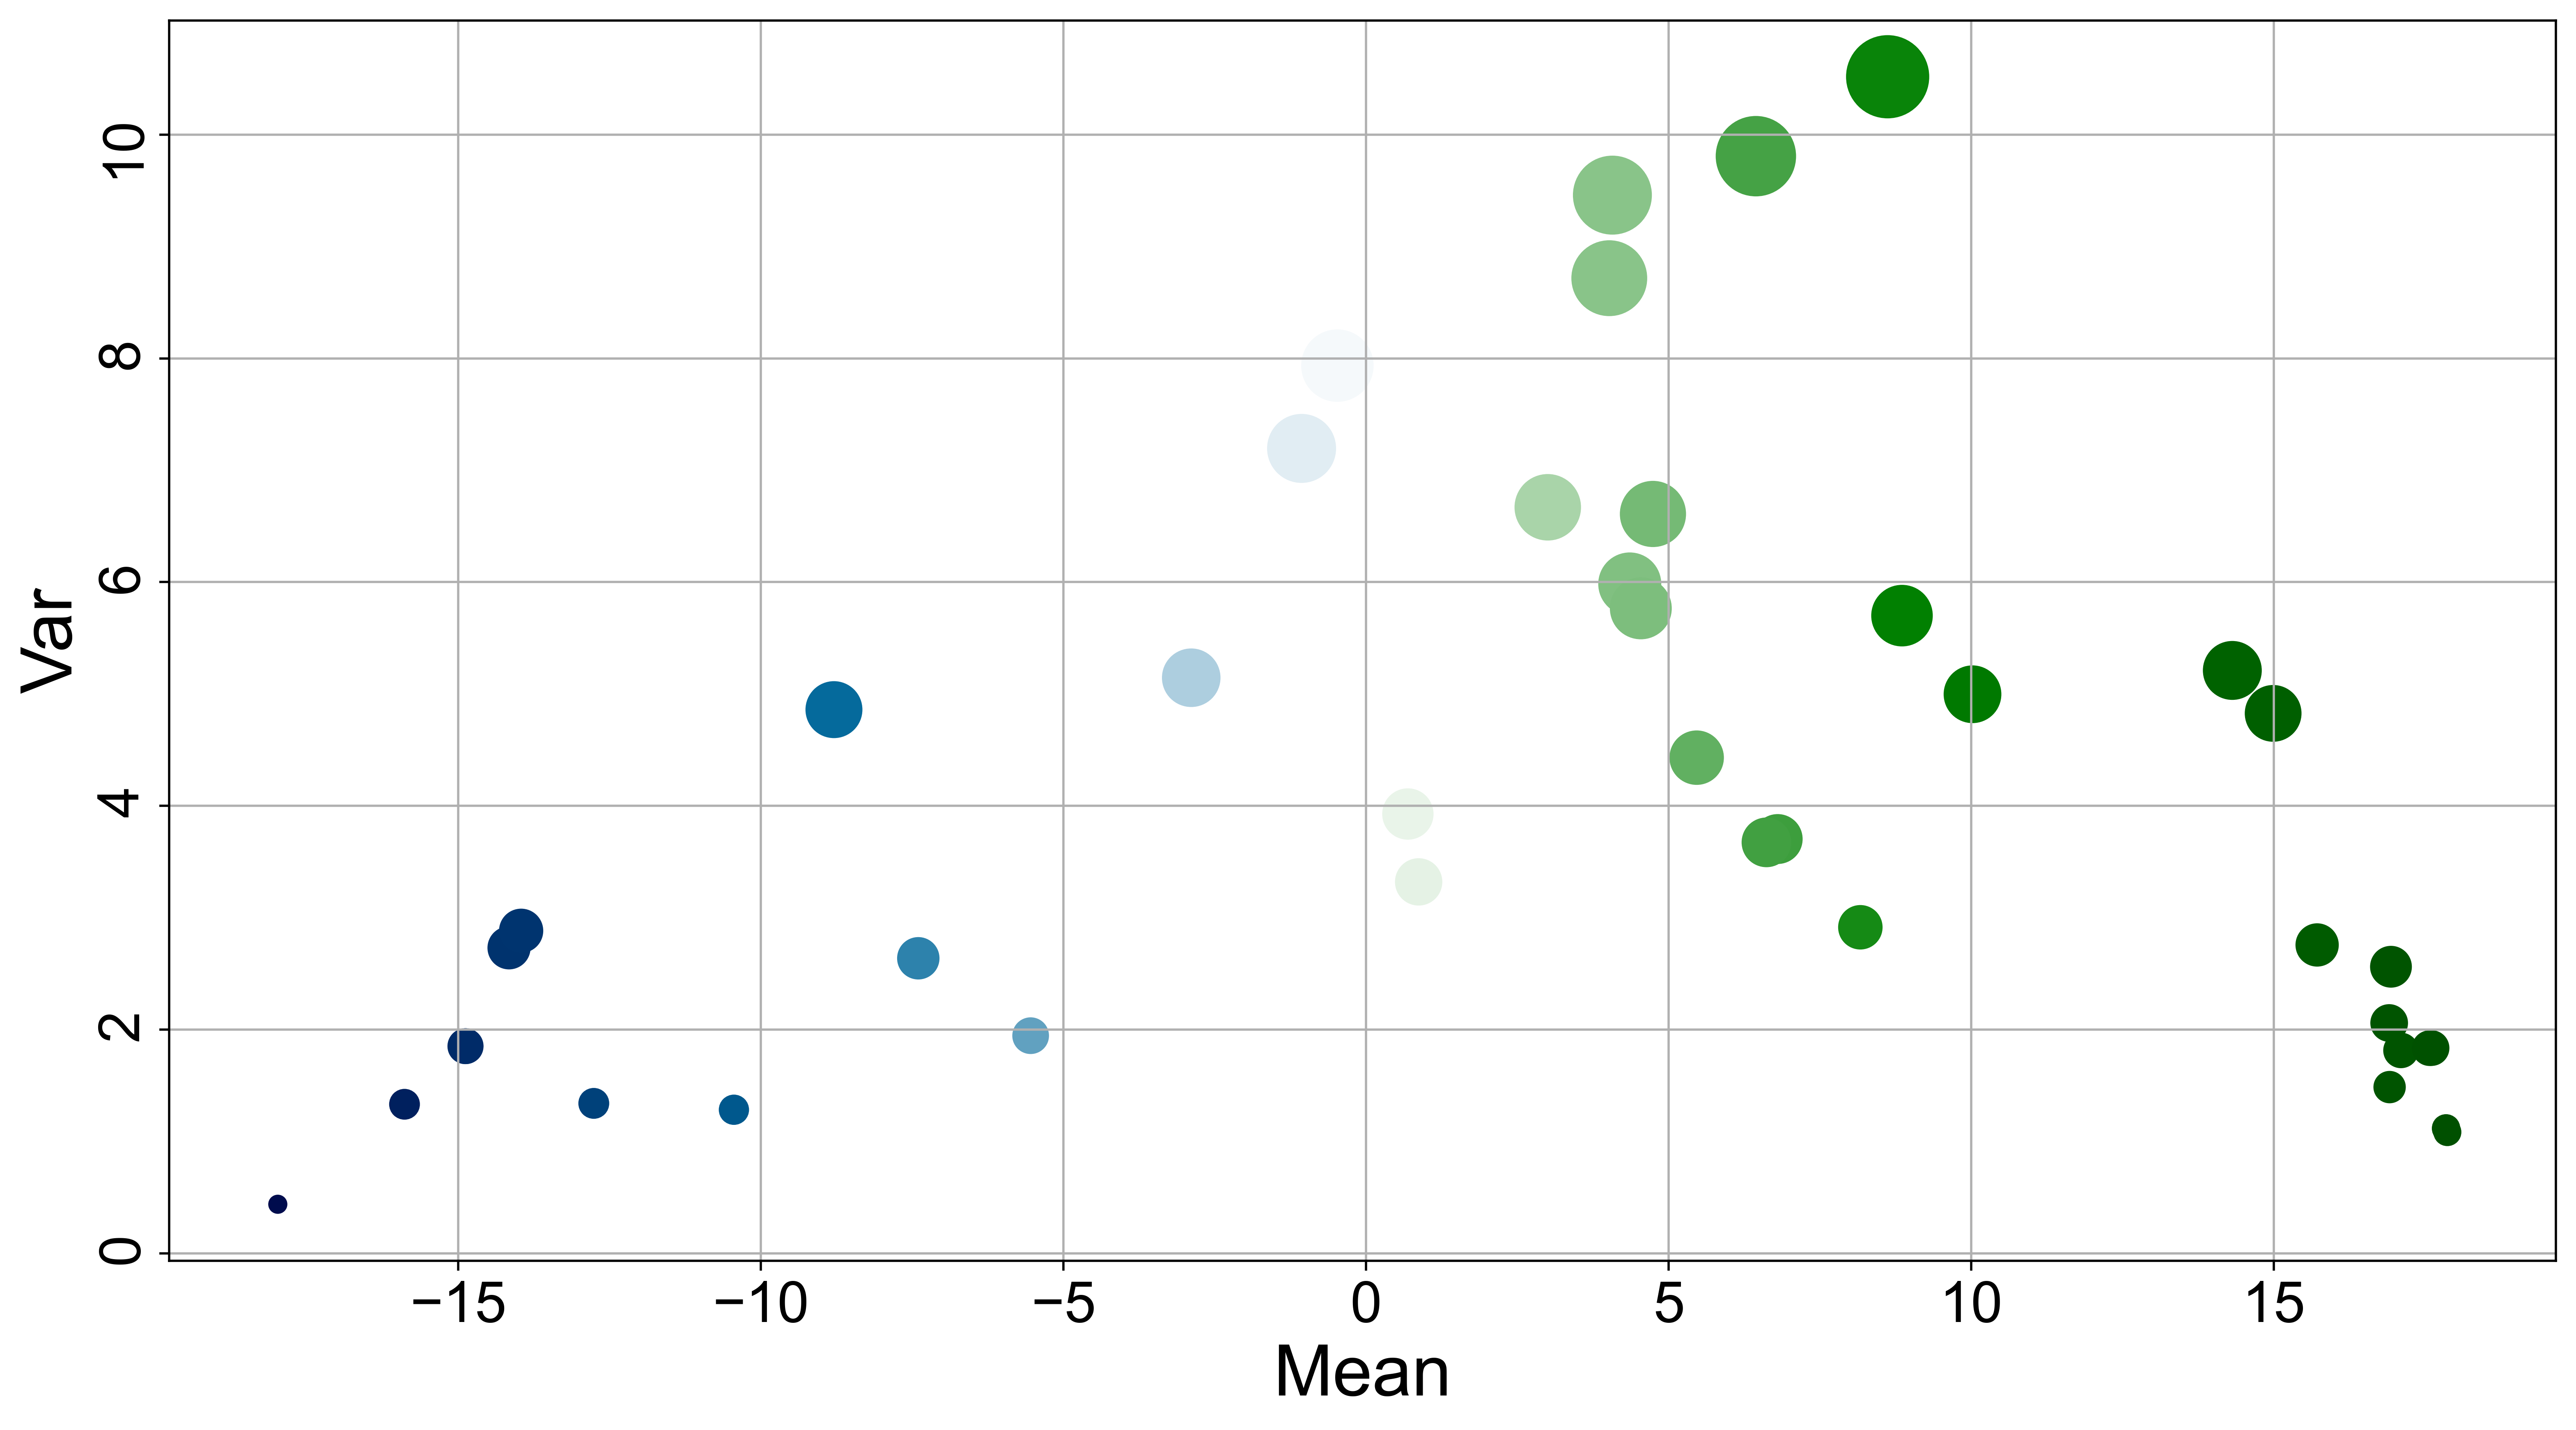

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

# for gg in range(3):
gg=0
x = fiber_contri_mean_lm_change[:, gg]
y = fiber_contri_var_lm_change[:, gg]

plt.figure(figsize=(15, 8), dpi=500)
cm = plt.cm.get_cmap('RdBu_r')
clist=['#000C4D', '#00679A', '#FFFFFF', '#007F00', '#005000']
cm = LinearSegmentedColormap.from_list('chaos',clist)
plt.scatter(x, y, 
            # s=600,
            s=y*80+10, 
            # c=fiber_lm_color_hex, 
            c=x,
            cmap=cm,
            # edgecolors=fiber_lm_color_hex, 
            linewidths=[0],
            ) # alpha=0.7,

# for i in range(len(x)):
#     t = label_name_lm_change[i]
#     plt.text(x[i], y[i], t, fontdict={'family' : 'Arial', 'size' : 10})
    
plt.xlabel("Mean", fontdict={'family' : 'Arial', 'size' : 25})
plt.ylabel("Var",  fontdict={'family' : 'Arial', 'size' : 25})
# x_major_locator=MultipleLocator(0.5)
# y_major_locator=MultipleLocator(0.4)
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)
plt.yticks(fontproperties = 'Arial', size = 20, rotation = 90)
plt.xticks(fontproperties = 'Arial', size = 20)
plt.grid()
plt.savefig(f'/n02dat01/users/dyli/Grad_code/SA_appeal/figure/fiber_contri_41fibers_G{gg+1}_BuGr.eps', bbox_inches = 'tight',dpi = 700, format='eps')
plt.show()

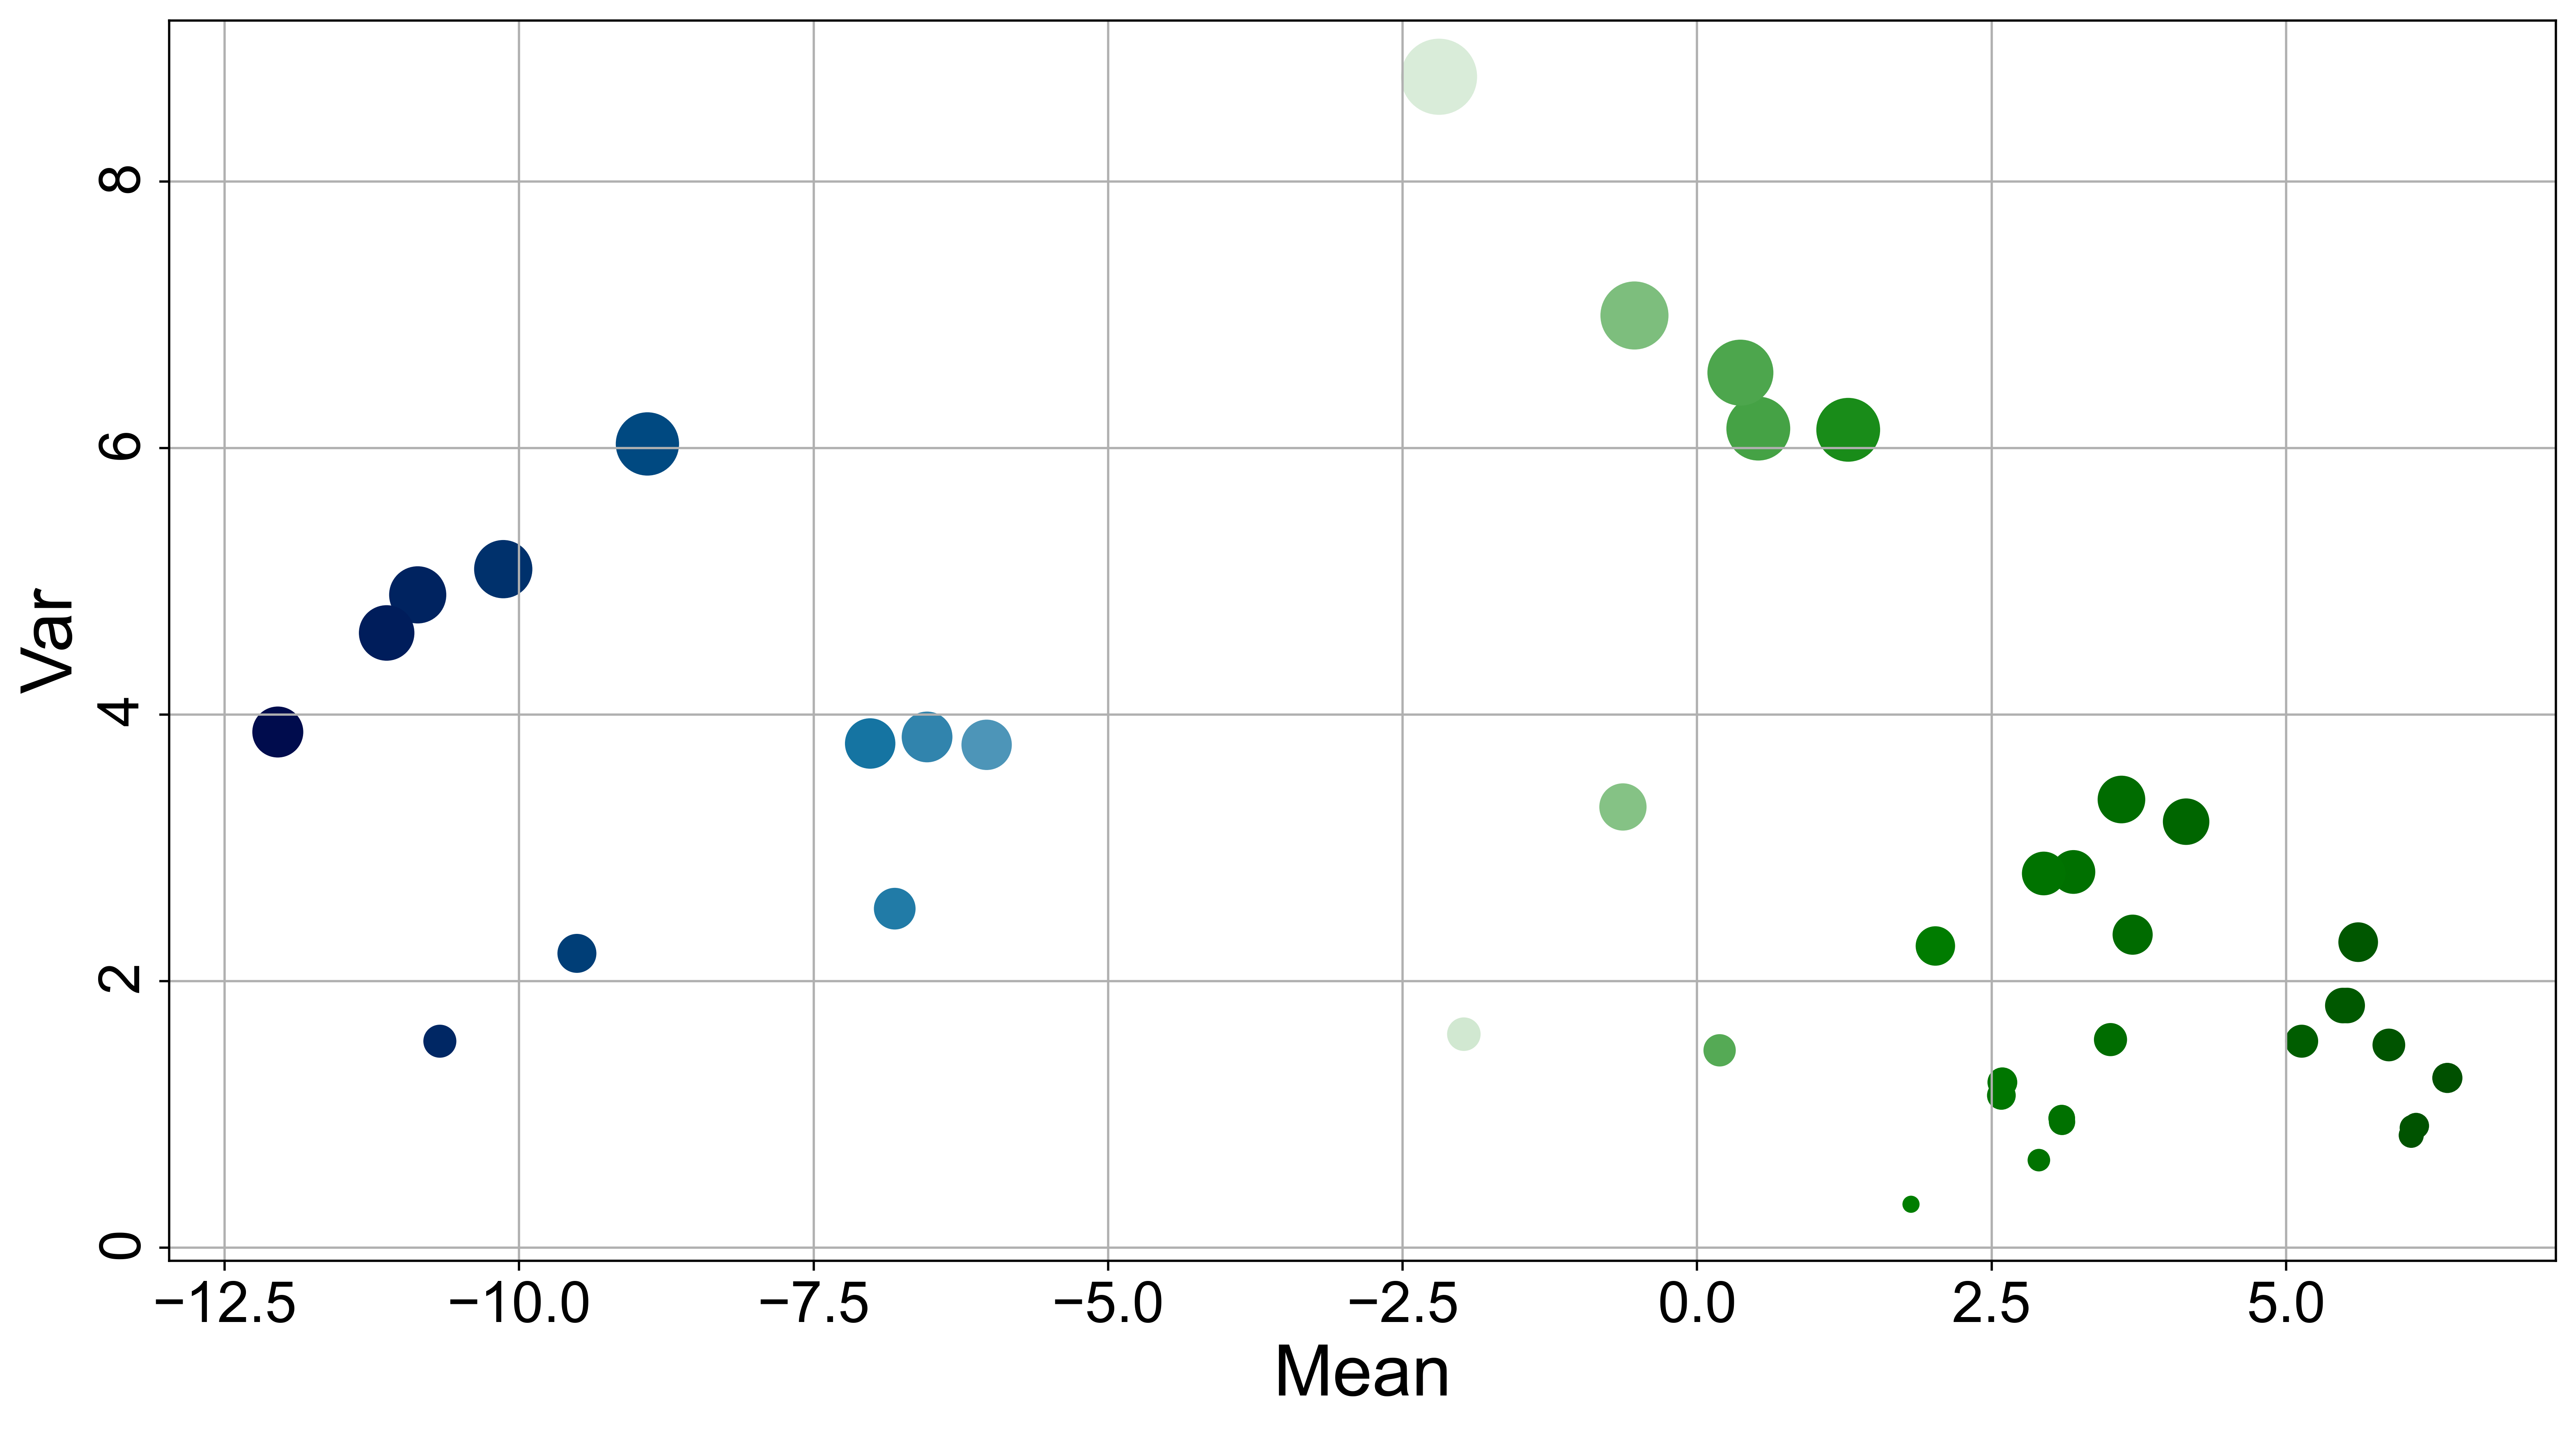

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

# for gg in range(3):
gg=1
x = fiber_contri_mean_lm_change[:, gg]
y = fiber_contri_var_lm_change[:, gg]

plt.figure(figsize=(15, 8), dpi=500)
cm = plt.cm.get_cmap('RdBu_r')
clist=['#000C4D', '#00679A', '#FFFFFF', '#007F00', '#005000']
cm = LinearSegmentedColormap.from_list('chaos',clist)
plt.scatter(x, y, 
            # s=600,
            s=y*80+10, 
            # c=fiber_lm_color_hex, 
            c=x,
            cmap=cm,
            # edgecolors=fiber_lm_color_hex, 
            linewidths=[0],
            ) # alpha=0.7,

# for i in range(len(x)):
#     t = label_name_lm_change[i]
#     plt.text(x[i], y[i], t, fontdict={'family' : 'Arial', 'size' : 10})
    
plt.xlabel("Mean", fontdict={'family' : 'Arial', 'size' : 25})
plt.ylabel("Var",  fontdict={'family' : 'Arial', 'size' : 25})
# x_major_locator=MultipleLocator(0.5)
# y_major_locator=MultipleLocator(0.4)
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)
plt.yticks(fontproperties = 'Arial', size = 20, rotation = 90)
plt.xticks(fontproperties = 'Arial', size = 20)
plt.grid()
plt.savefig(f'/n02dat01/users/dyli/Grad_code/SA_appeal/figure/fiber_contri_41fibers_G{gg+1}_BuGr.eps', bbox_inches = 'tight',dpi = 700, format='eps')
plt.show()

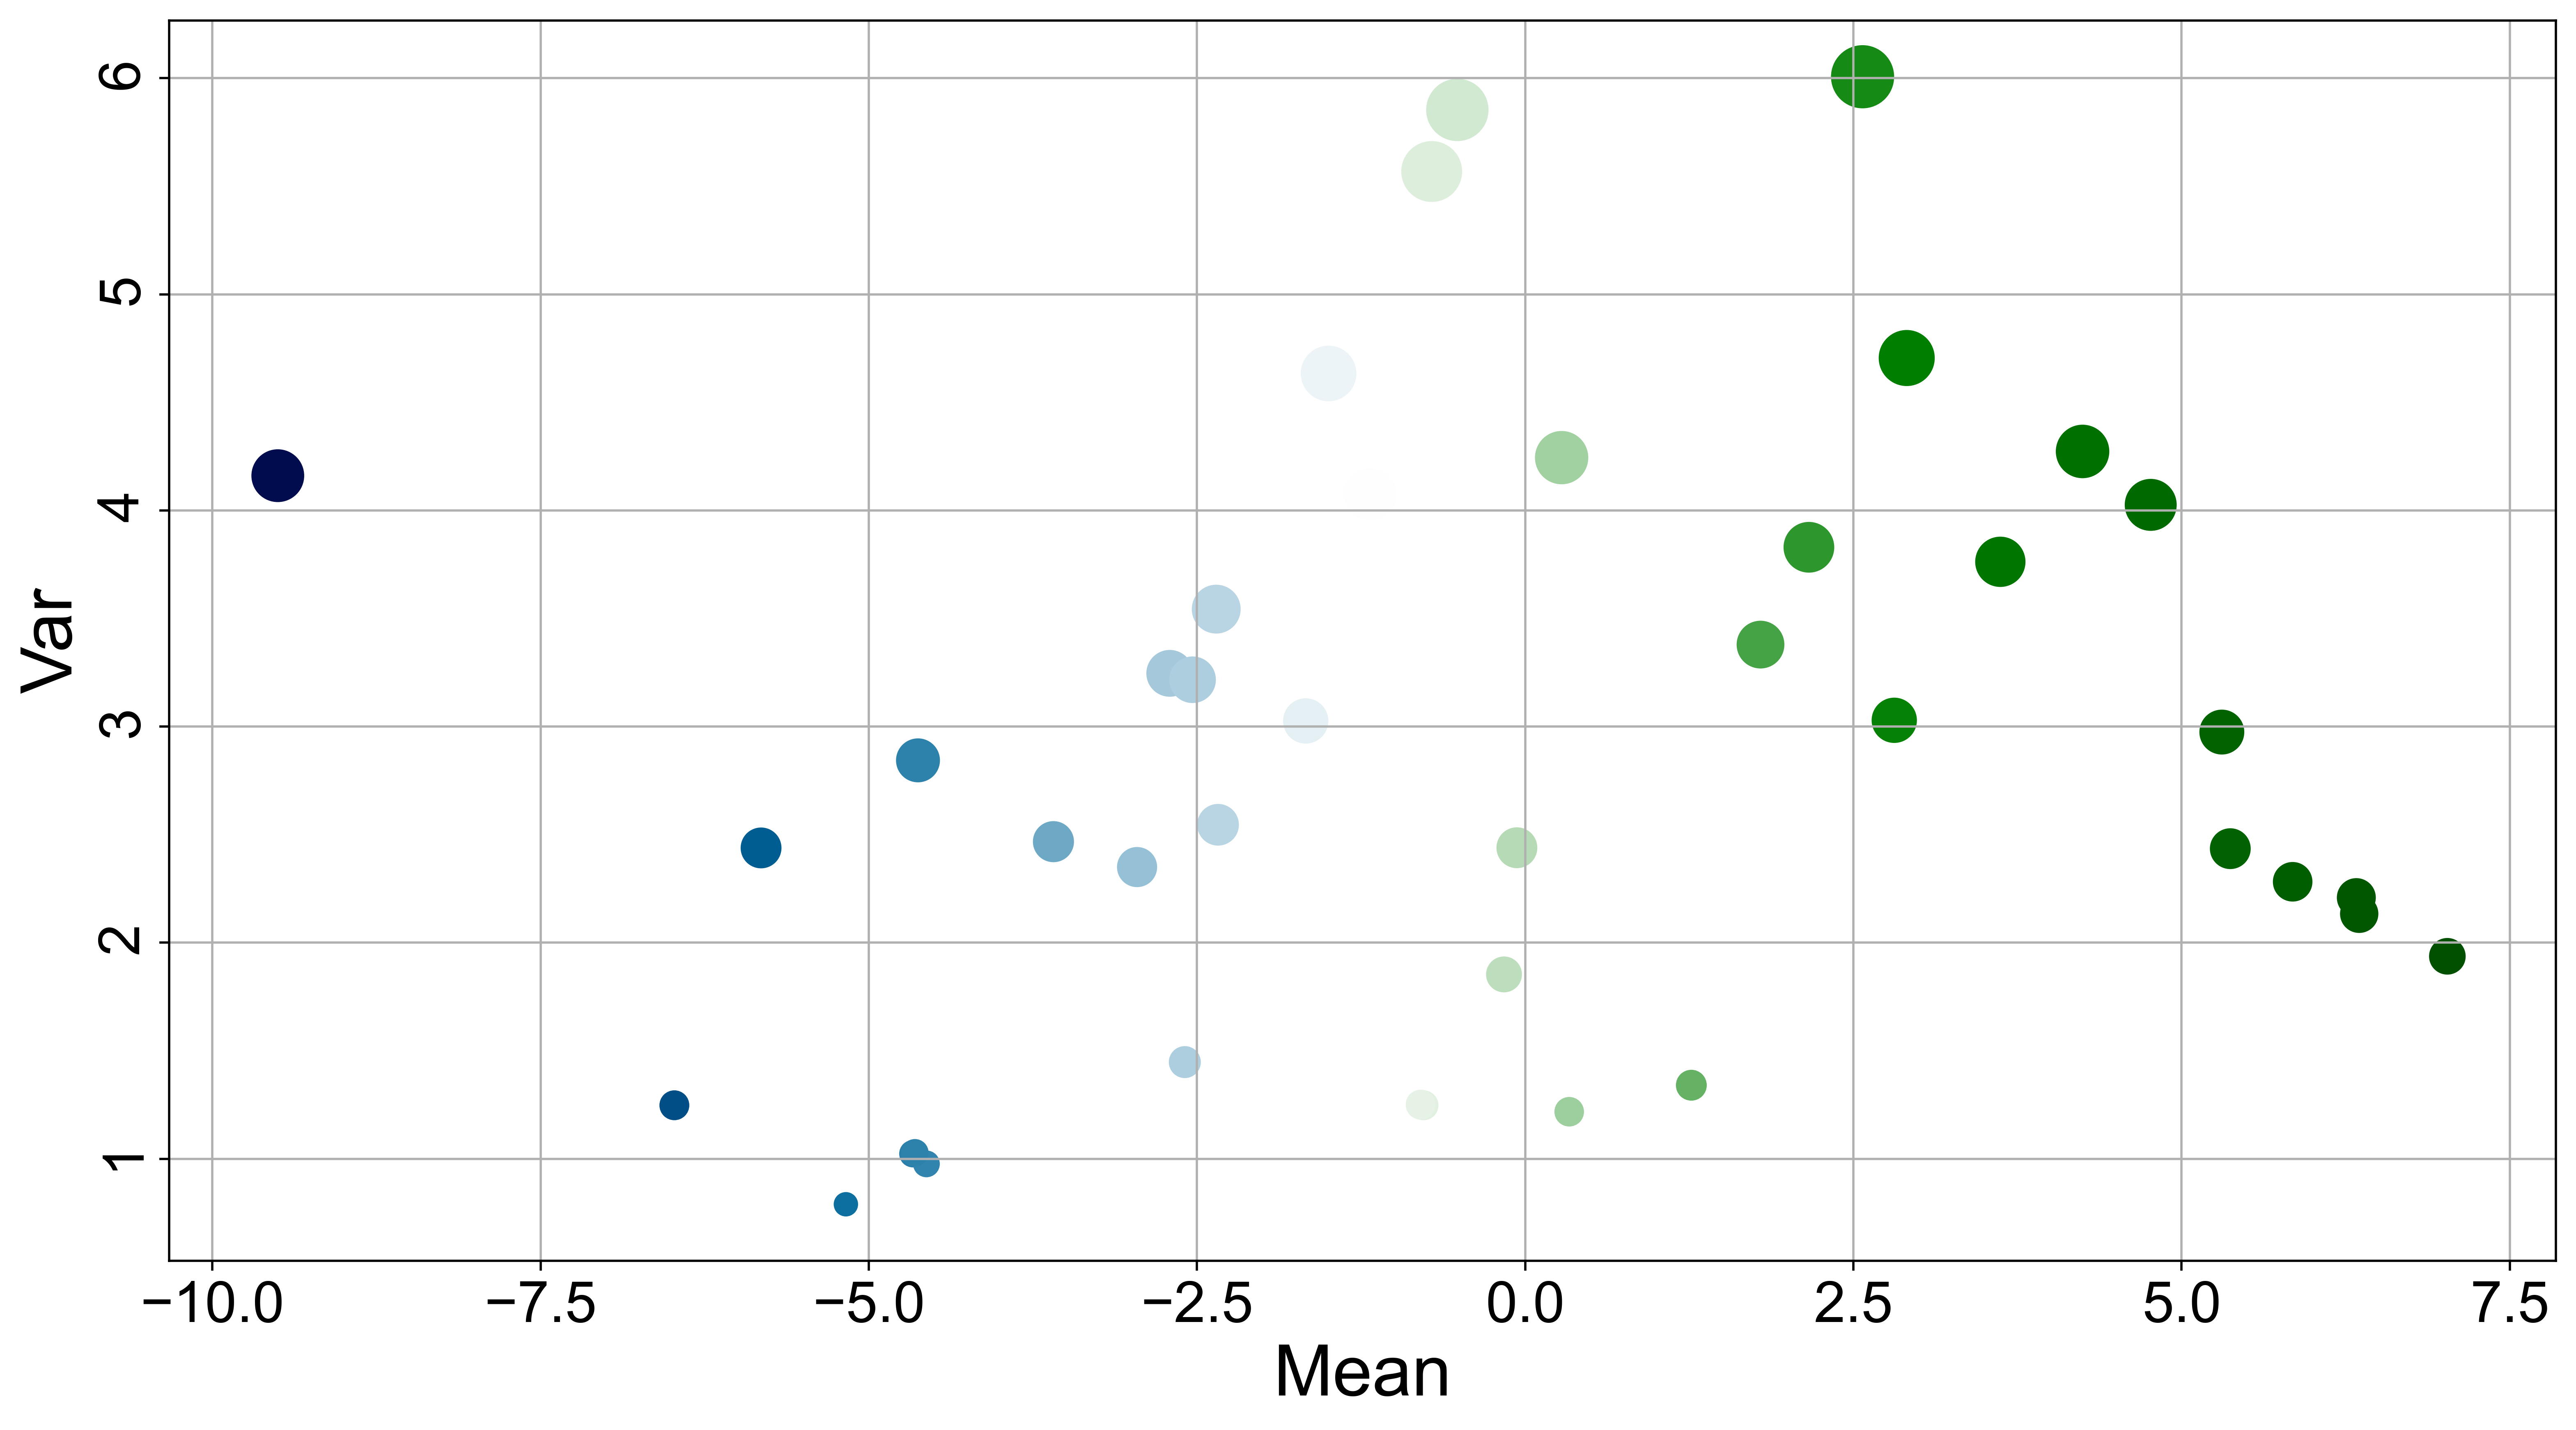

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

# for gg in range(3):
gg=2
x = fiber_contri_mean_lm_change[:, gg]
y = fiber_contri_var_lm_change[:, gg]

plt.figure(figsize=(15, 8), dpi=500)
cm = plt.cm.get_cmap('RdBu_r')
clist=['#000C4D', '#00679A', '#FFFFFF', '#007F00', '#005000']
cm = LinearSegmentedColormap.from_list('chaos',clist)
plt.scatter(x, y, 
            # s=600,
            s=y*80+10, 
            # c=fiber_lm_color_hex, 
            c=x,
            cmap=cm,
            # edgecolors=fiber_lm_color_hex, 
            linewidths=[0],
            ) # alpha=0.7,

# for i in range(len(x)):
#     t = label_name_lm_change[i]
#     plt.text(x[i], y[i], t, fontdict={'family' : 'Arial', 'size' : 10})
    
plt.xlabel("Mean", fontdict={'family' : 'Arial', 'size' : 25})
plt.ylabel("Var",  fontdict={'family' : 'Arial', 'size' : 25})
# x_major_locator=MultipleLocator(0.5)
# y_major_locator=MultipleLocator(0.4)
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)
plt.yticks(fontproperties = 'Arial', size = 20, rotation = 90)
plt.xticks(fontproperties = 'Arial', size = 20)
plt.grid()
plt.savefig(f'/n02dat01/users/dyli/Grad_code/SA_appeal/figure/fiber_contri_41fibers_G{gg+1}_BuGr.eps', bbox_inches = 'tight',dpi = 700, format='eps')
plt.show()

# old plotting

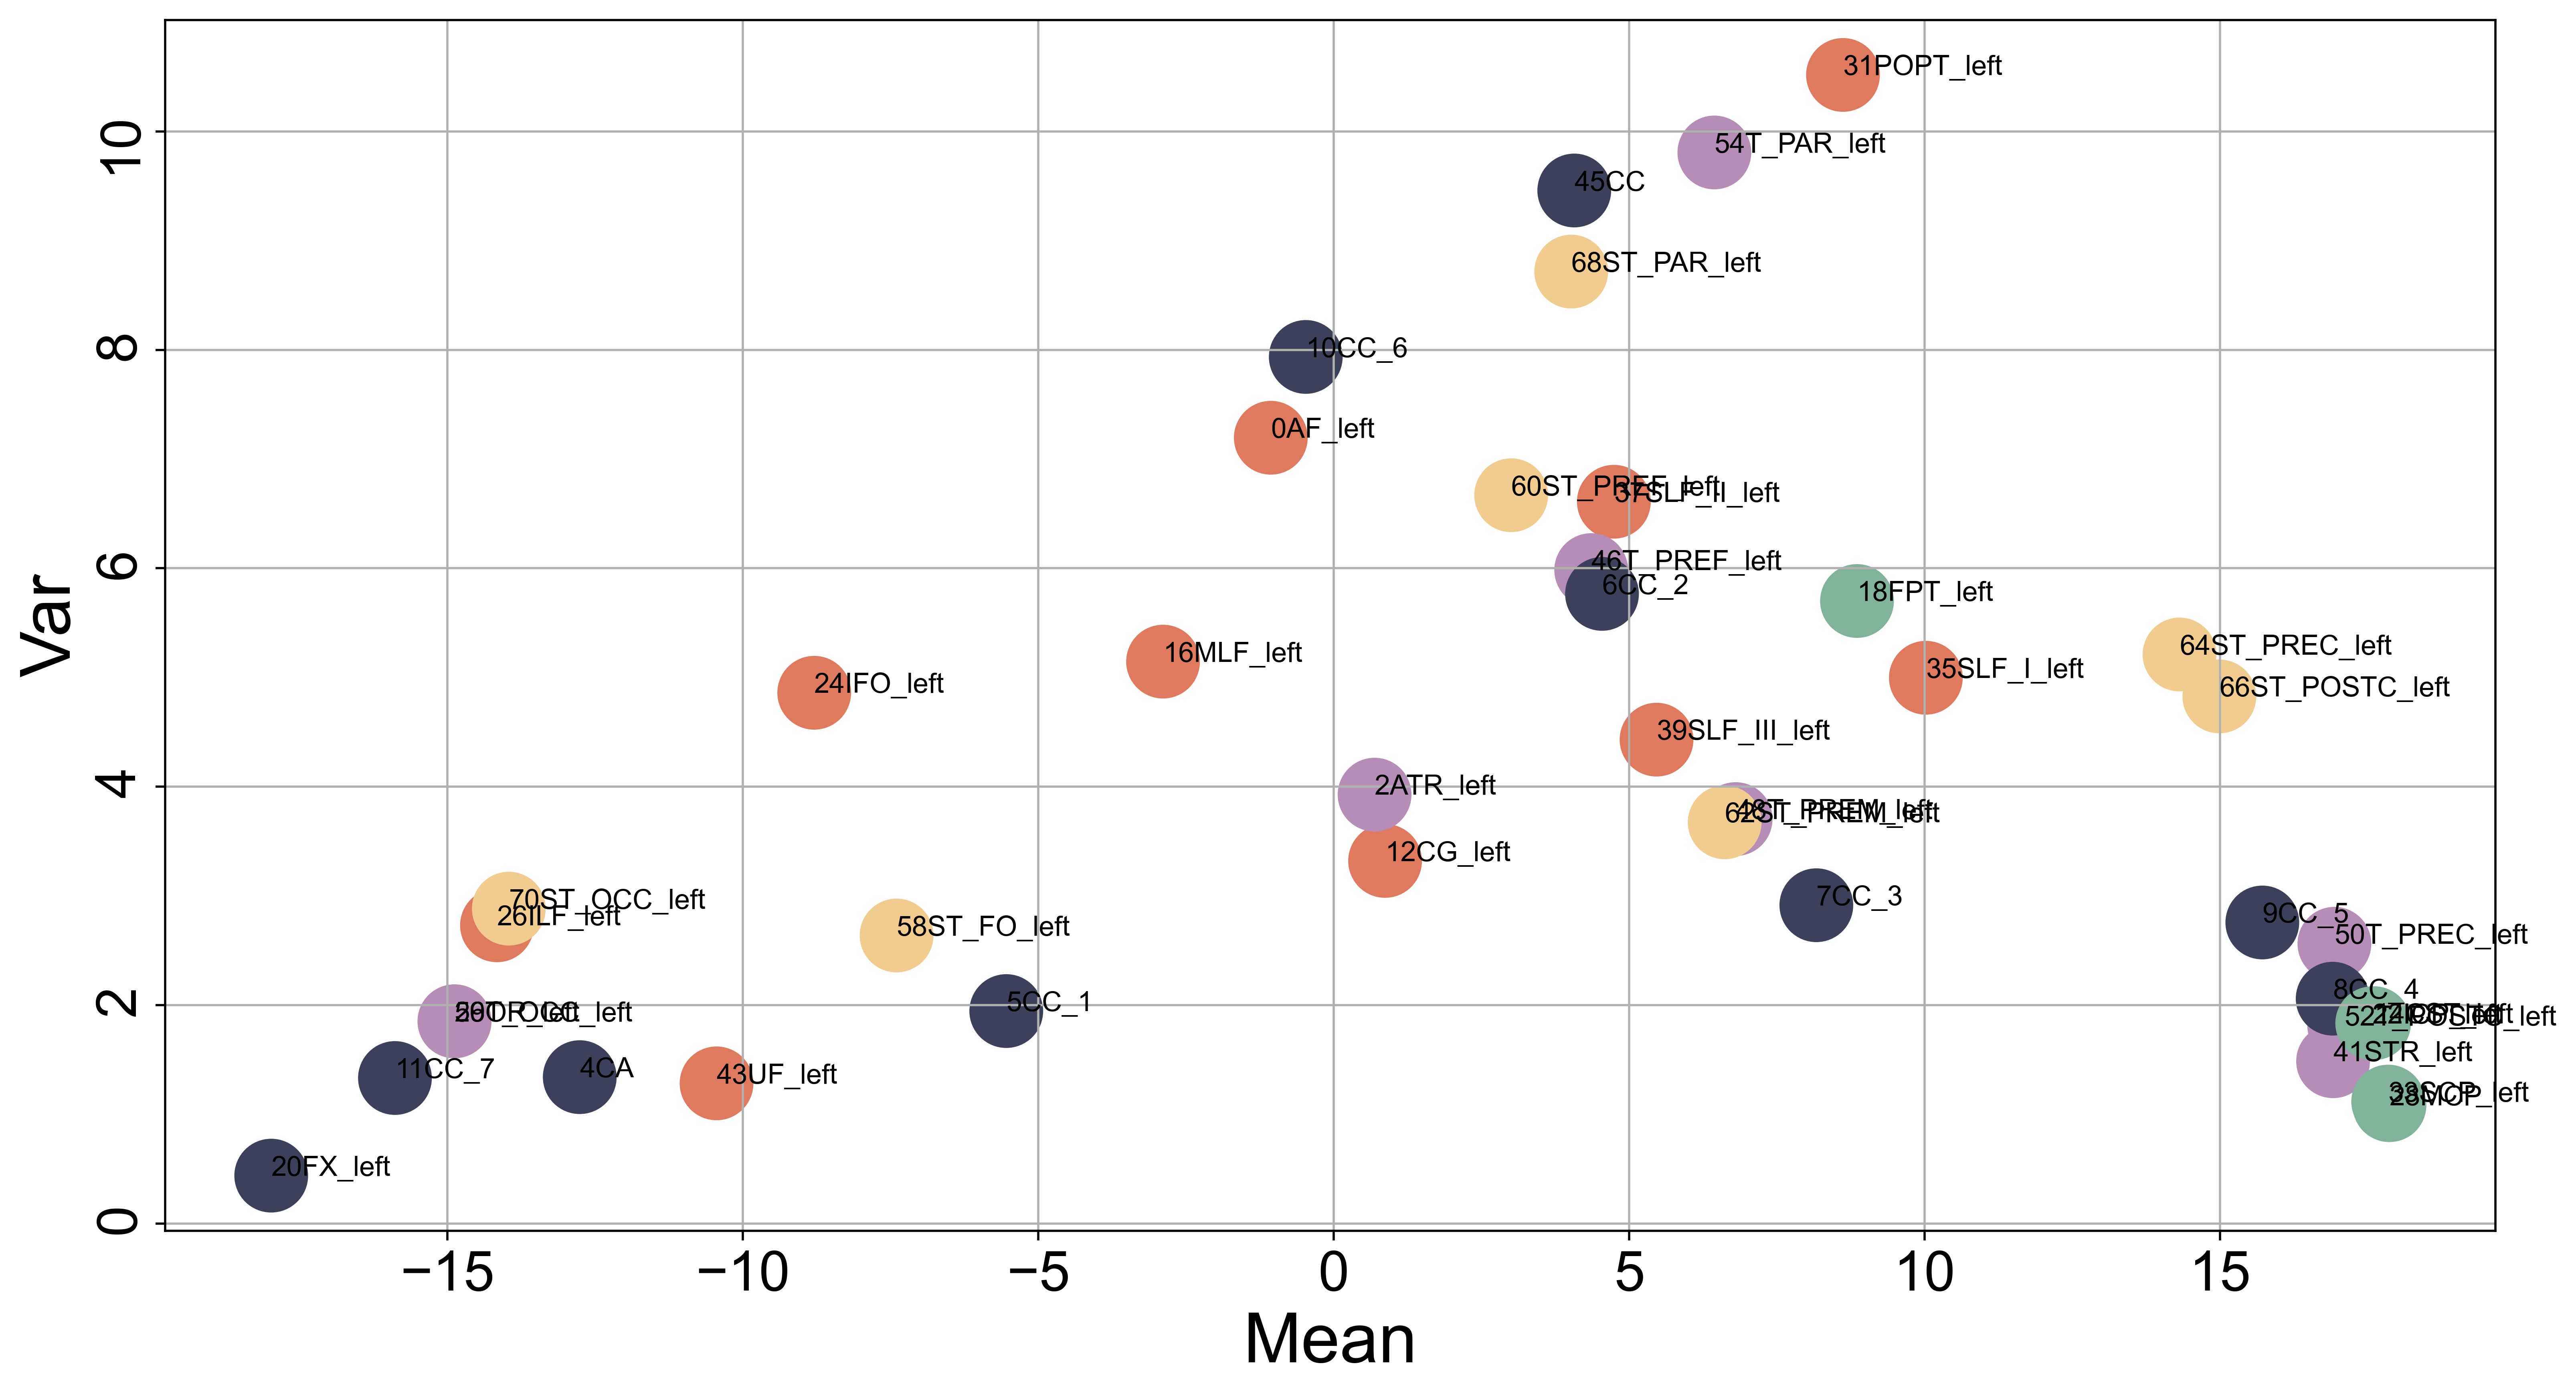

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

# for gg in range(3):
gg=0
x = fiber_contri_mean_lm_change[:, gg]
y = fiber_contri_var_lm_change[:, gg]

plt.figure(figsize=(15, 8), dpi=500)
plt.scatter(x, y, s=600, c=fiber_lm_color_hex, edgecolors=fiber_lm_color_hex, linewidths=[2]) # alpha=0.7,

for i in range(len(x)):
    t = label_name_lm_change[i]
    plt.text(x[i], y[i], t, fontdict={'family' : 'Arial', 'size' : 10})
    
plt.xlabel("Mean", fontdict={'family' : 'Arial', 'size' : 25})
plt.ylabel("Var",  fontdict={'family' : 'Arial', 'size' : 25})
# x_major_locator=MultipleLocator(0.5)
# y_major_locator=MultipleLocator(0.4)
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)
plt.yticks(fontproperties = 'Arial', size = 20, rotation = 90)
plt.xticks(fontproperties = 'Arial', size = 20)
plt.grid()
# plt.savefig(f'/n02dat01/users/dyli/Grad_code/SA_appeal/figure/fiber_contri_41fibers_G{gg+1}.eps', bbox_inches = 'tight',dpi = 700, format='eps')
plt.show()

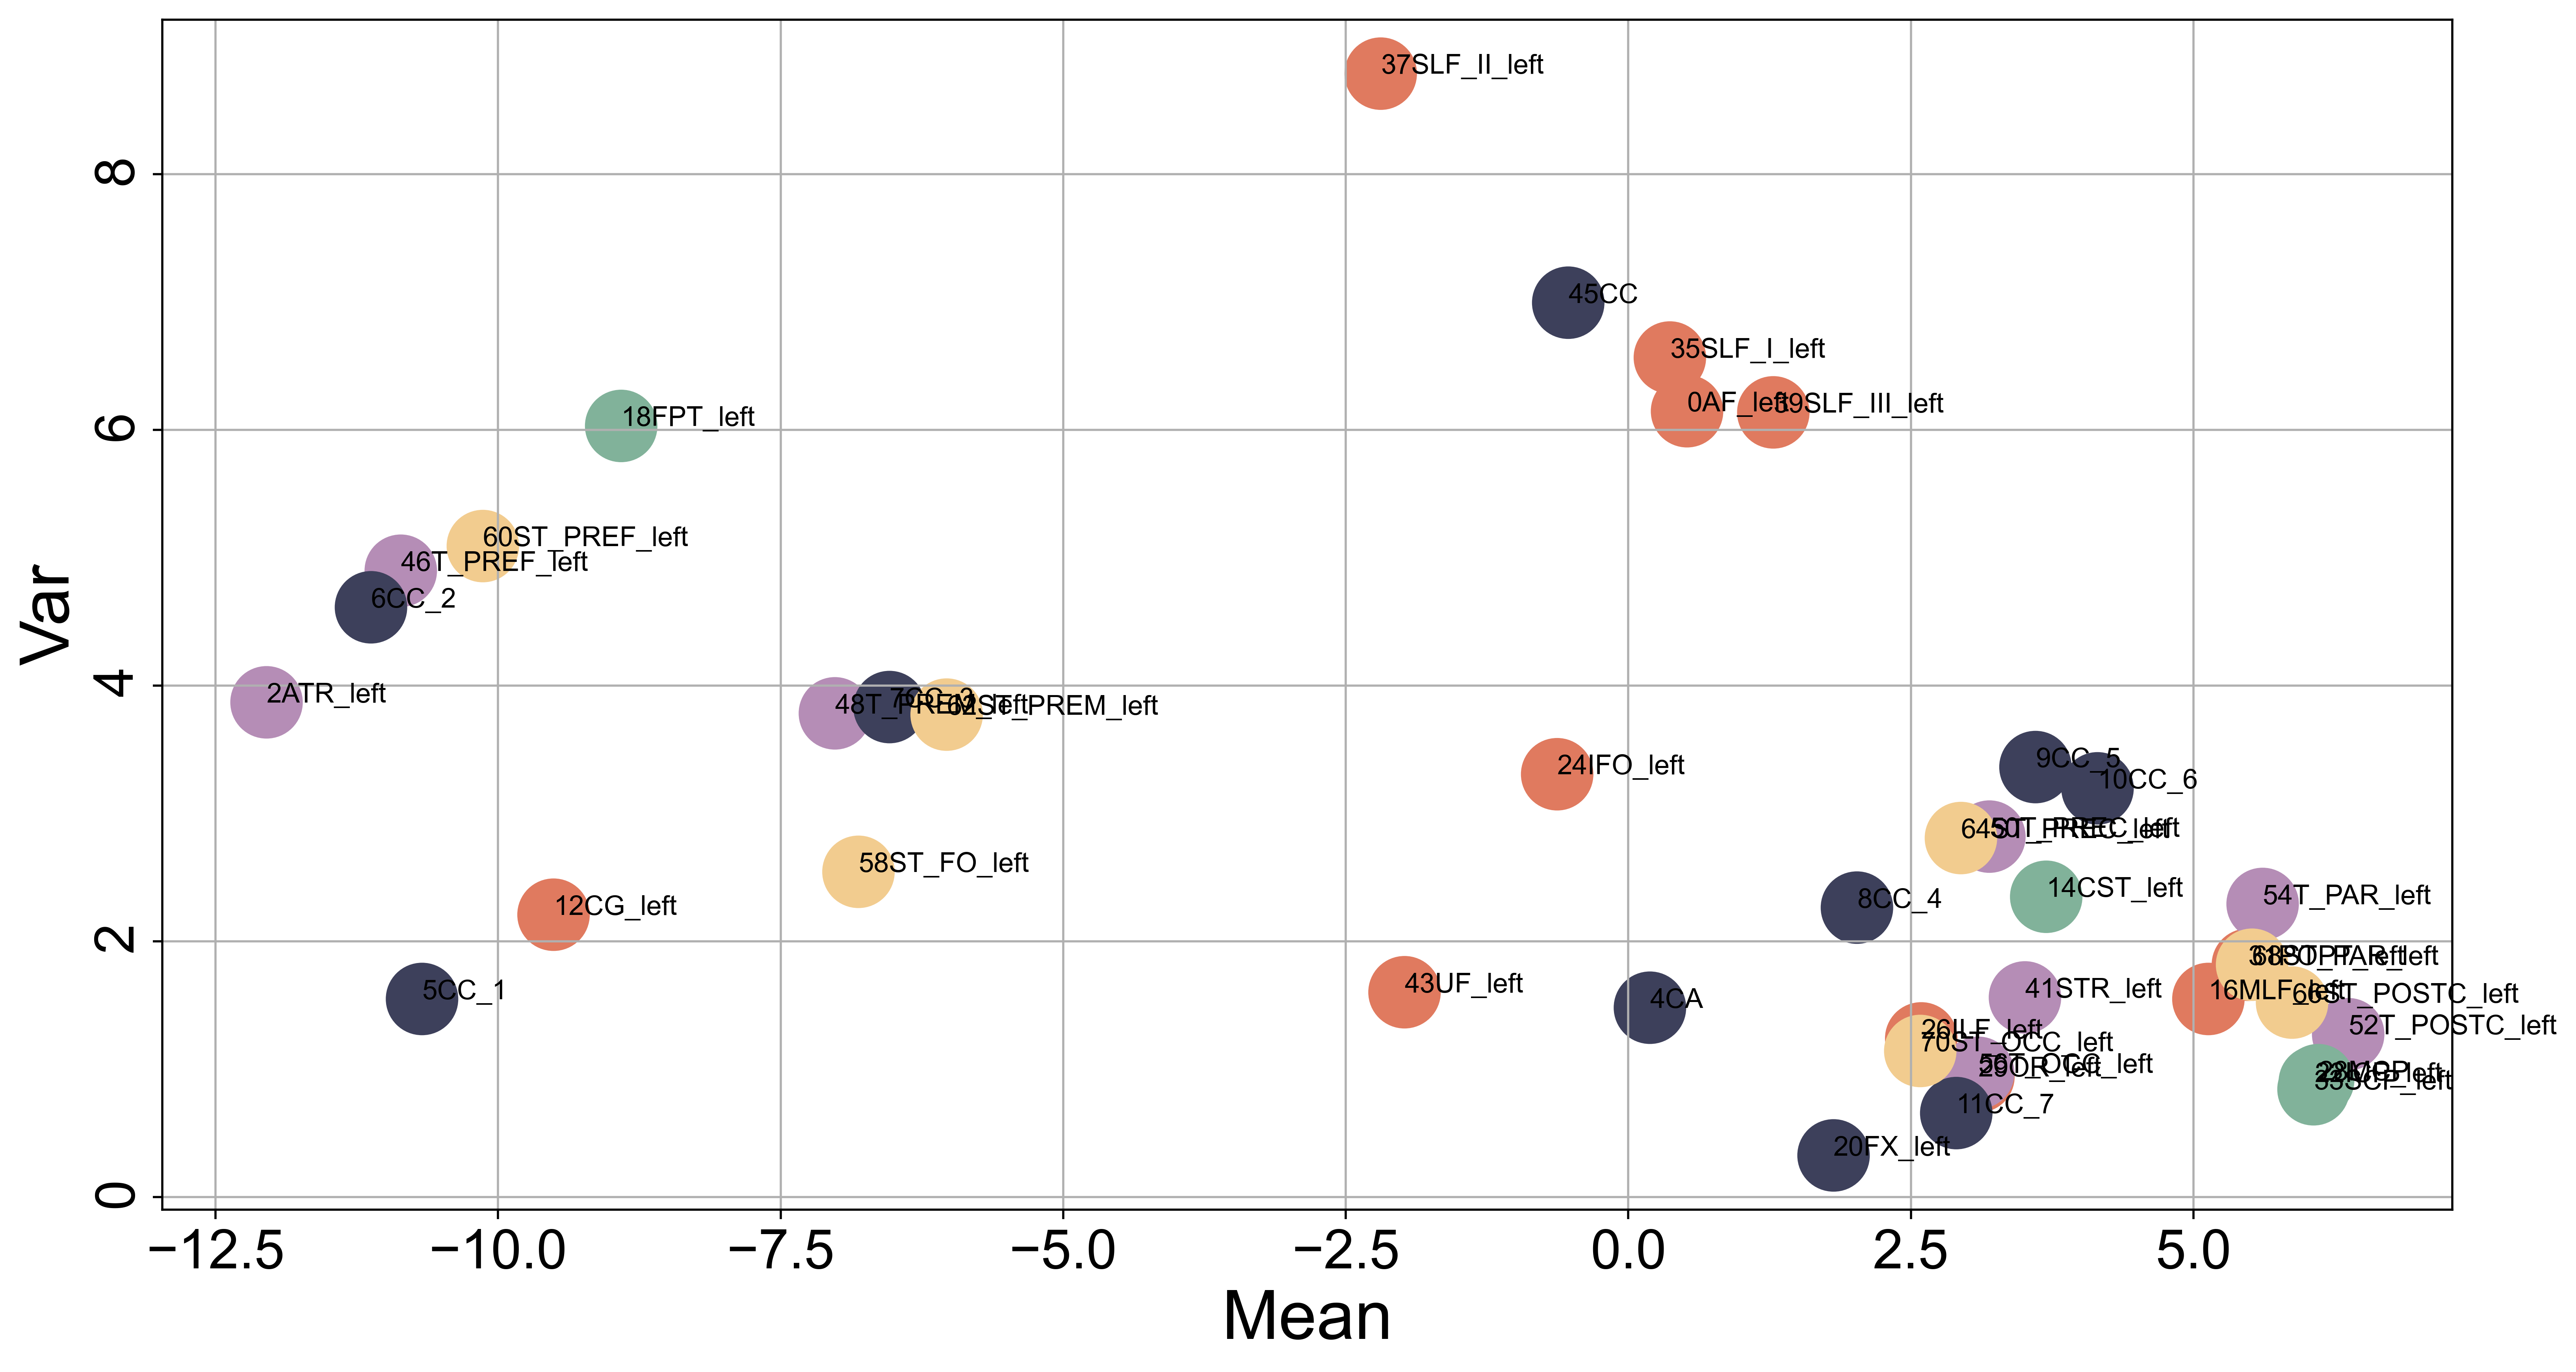

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

# for gg in range(3):
gg=1
x = fiber_contri_mean_lm_change[:, gg]
y = fiber_contri_var_lm_change[:, gg]

plt.figure(figsize=(15, 8), dpi=500)
plt.scatter(x, y, s=600, c=fiber_lm_color_hex, edgecolors=fiber_lm_color_hex, linewidths=[2]) # alpha=0.7,

for i in range(len(x)):
    t = label_name_lm_change[i]
    plt.text(x[i], y[i], t, fontdict={'family' : 'Arial', 'size' : 10})
    
plt.xlabel("Mean", fontdict={'family' : 'Arial', 'size' : 25})
plt.ylabel("Var",  fontdict={'family' : 'Arial', 'size' : 25})
# x_major_locator=MultipleLocator(0.25)
# y_major_locator=MultipleLocator(0.2)
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)
# plt.xlim(-2,2.5)
# plt.ylim(-0.5, 2)
plt.yticks(fontproperties = 'Arial', size = 20, rotation = 90)
plt.xticks(fontproperties = 'Arial', size = 20)
plt.grid()
# plt.savefig(f'/n02dat01/users/dyli/Grad_code/SA_appeal/figure/fiber_contri_41fibers_G{gg+1}.eps', bbox_inches = 'tight',dpi = 700, format='eps')
plt.show()

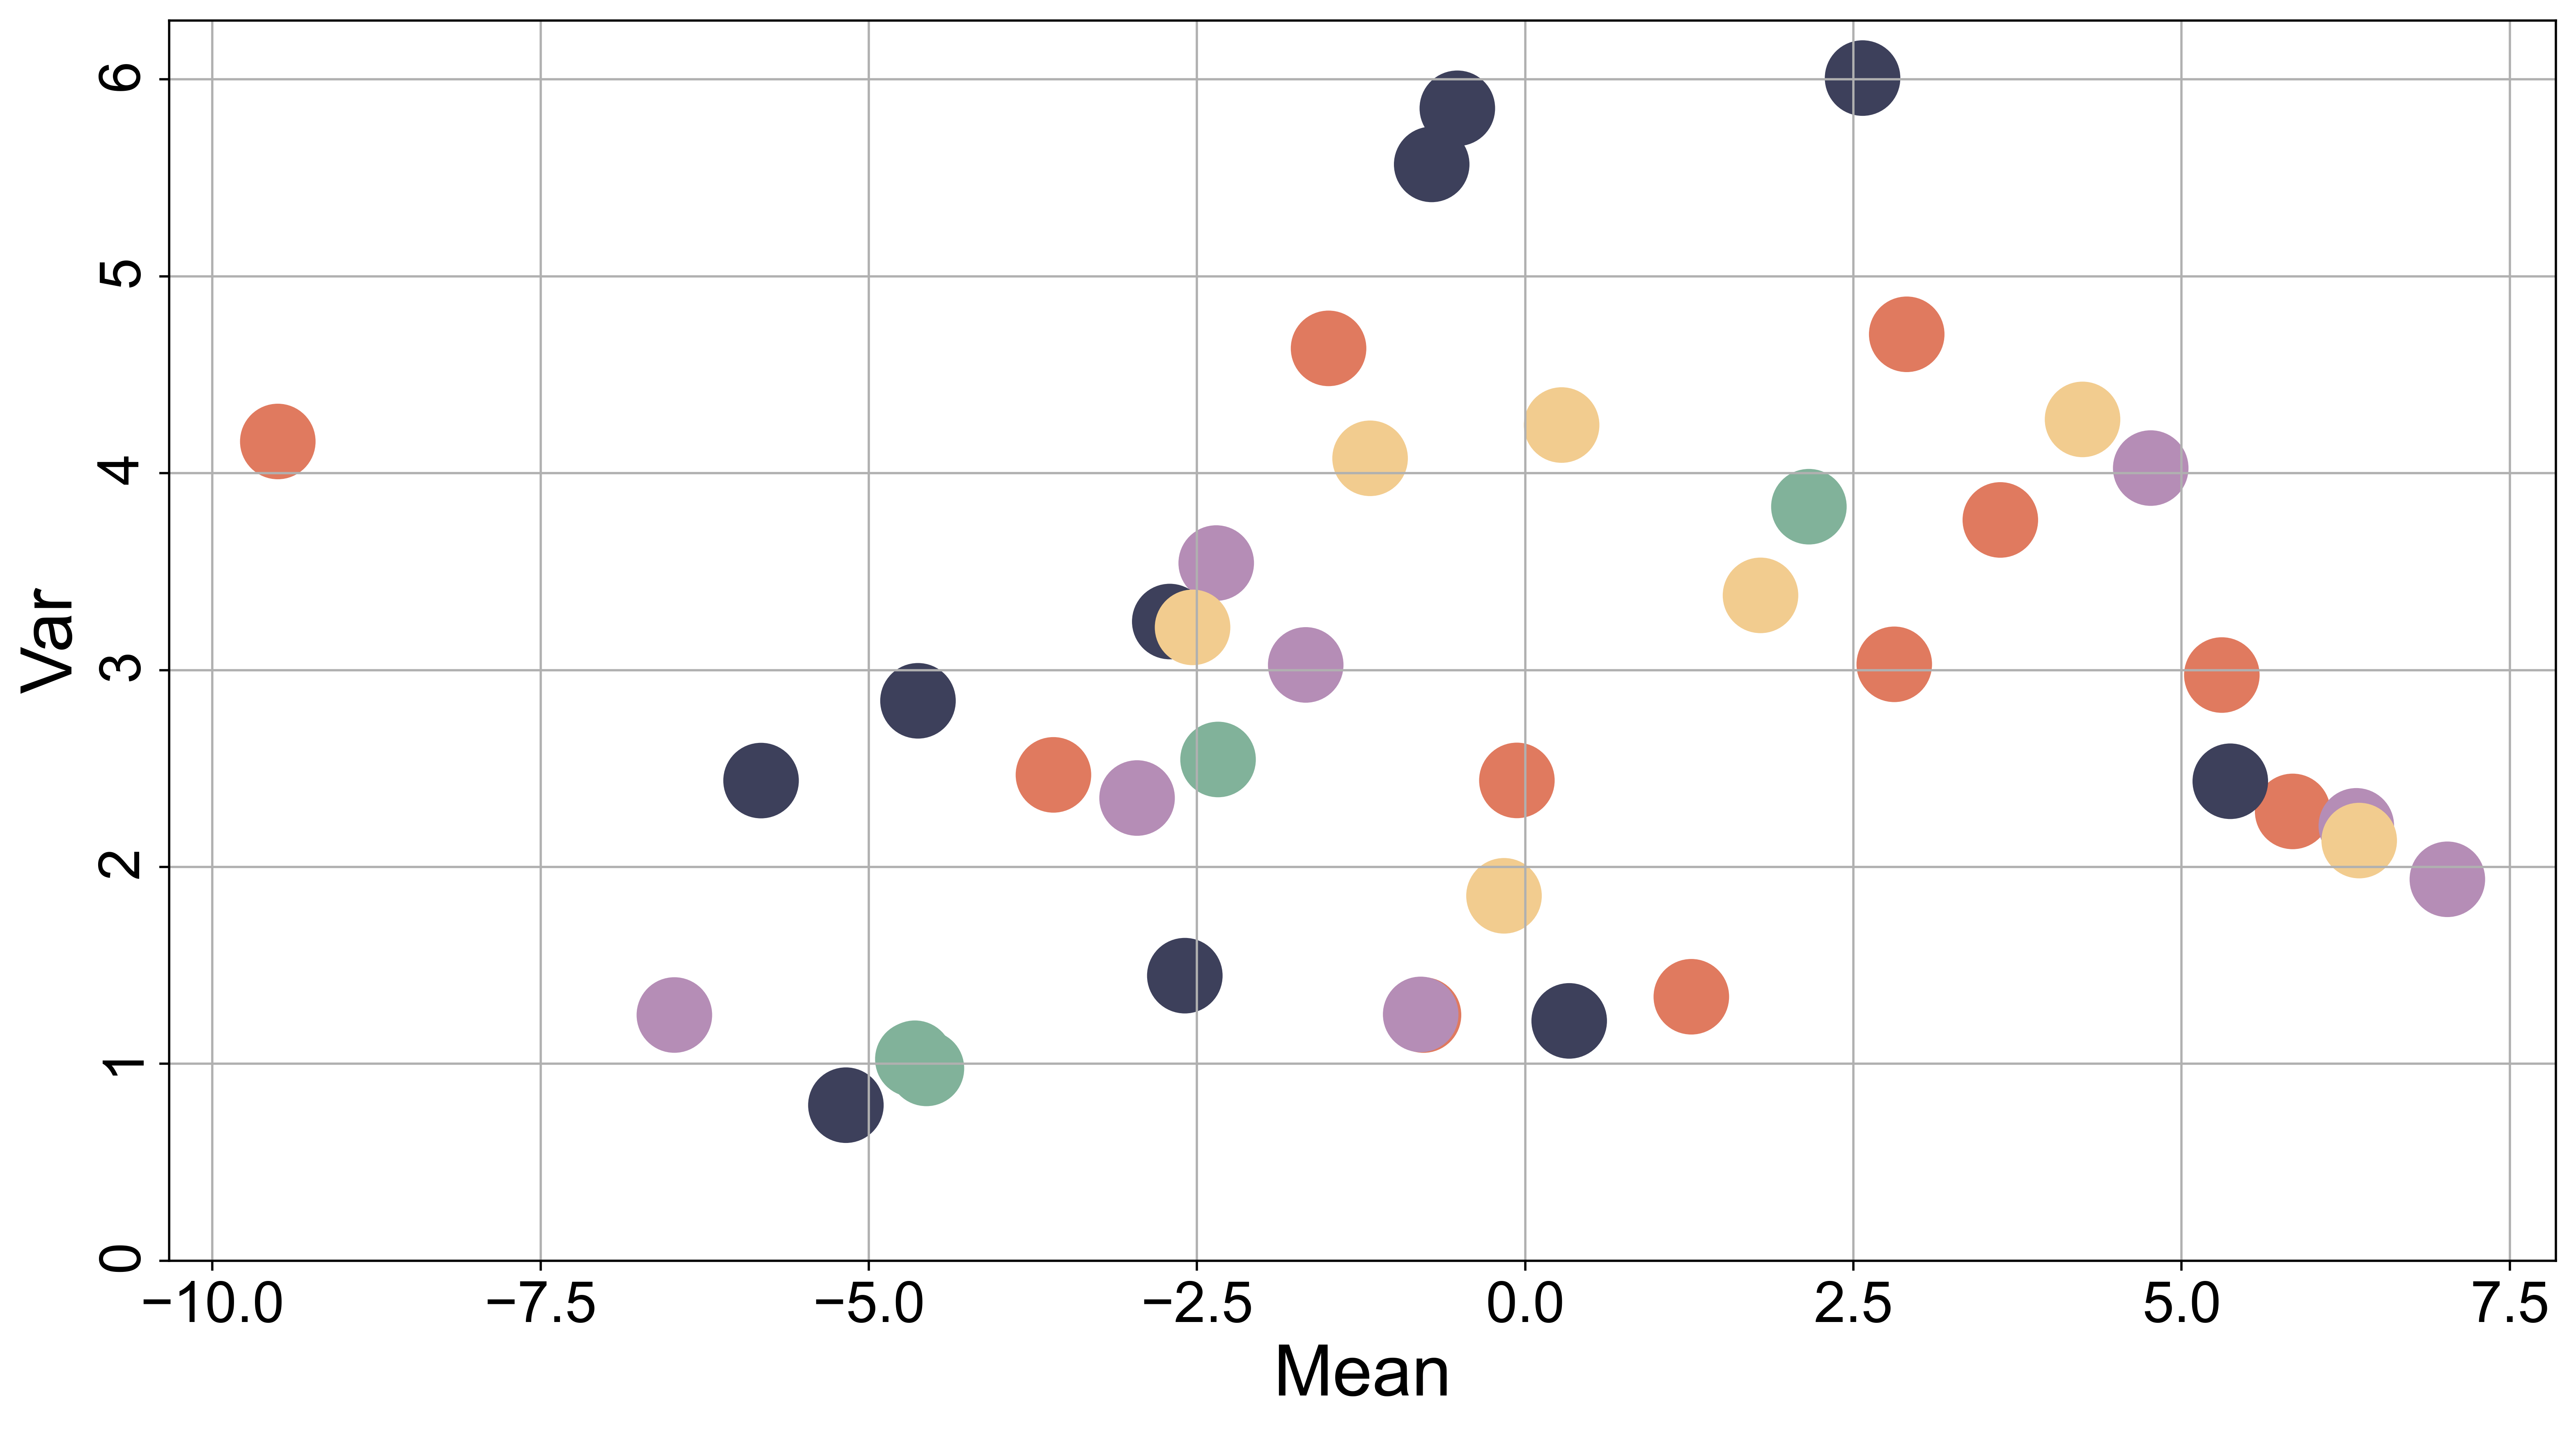

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

# for gg in range(3):
gg=2
x = fiber_contri_mean_lm_change[:, gg]
y = fiber_contri_var_lm_change[:, gg]

plt.figure(figsize=(15, 8), dpi=500)
plt.scatter(x, y, s=600, c=fiber_lm_color_hex, edgecolors=fiber_lm_color_hex, linewidths=[2]) # alpha=0.7,

# for i in range(len(x)):
#     t = label_name_lm_change[i]
#     plt.text(x[i], y[i], t, fontdict={'family' : 'Arial', 'size' : 10})
    
plt.xlabel("Mean", fontdict={'family' : 'Arial', 'size' : 25})
plt.ylabel("Var",  fontdict={'family' : 'Arial', 'size' : 25})
# x_major_locator=MultipleLocator(0.2)
# y_major_locator=MultipleLocator(0.2)
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)
# plt.xlim(-2,2.5)
plt.ylim(0, 6.3)
plt.yticks(fontproperties = 'Arial', size = 20, rotation = 90)
plt.xticks(fontproperties = 'Arial', size = 20)
plt.grid()
plt.savefig(f'/n02dat01/users/dyli/Grad_code/SA_appeal/figure/fiber_contri_41fibers_G{gg+1}.eps', bbox_inches = 'tight',dpi = 700, format='eps')
plt.show()

In [6]:
re_new_L = np.load('/n02dat01/users/dyli/Grad_data/support_data/Vertex_Fiber_L_100_add_norm_zeros_new.npy')
re_new_R = np.load('/n02dat01/users/dyli/Grad_data/support_data/Vertex_Fiber_R_100_add_norm_zeros_new.npy')
print(re_new_L.shape, re_new_R.shape)

(29696, 71) (29716, 71)


## new fiber contribution from SAr2

In [2]:
def zero_row_check(connection):
    # 检查 connection 是否有全 0 行
    for ii in range(connection.shape[0]):
        row = connection[ii, :]
        xx = np.unique(row)
        if len(xx) == 1:
            connection[ii, :] = connection[ii-1, :]
    for ii in range(connection.shape[0]):
        row = connection[ii, :]
        xx = np.unique(row)
        if len(xx) == 1:
            print(ii)
            sys.exit(0)
    return connection

# 读取 vertex 和 voxel 的 connection
connection = sps.load_npz('/n02dat01/users/dyli/Grad_data/support_data/reg_L.npz').toarray().astype(np.float32)
print(connection.shape)

connection = zero_row_check(connection)

(29696, 99880)


In [3]:
print(connection.shape)

(29696, 99880)


In [7]:
def find_max_idx(x: np.ndarray, n: np.int32) -> np.ndarray:
    # x: (59412, 1)
    # re: (1, n)
    re = np.zeros((x.shape[1], n))
    for i in range(x.shape[1]):
        col = x[:, i]
        col = np.squeeze(col)
        re[i,:] = np.argpartition(col, -1*n)[-1*n:]
    return re.astype(np.int32)

# 读取72条纤维束和全脑顶点的连接
connection = np.zeros((59412, 71))
connection[0:29696, :] = np.load(f'/n02dat01/users/dyli/Grad_data/support_data/Vertex_Fiber_L_100_add_norm_zeros_new.npy') # (29696, 72)
connection[29696:59412,:] = np.load(f'/n02dat01/users/dyli/Grad_data/support_data/Vertex_Fiber_R_100_add_norm_zeros_new.npy') # (29716, 72)
connection = connection/100

for i in range(connection.shape[0]):
    row = connection[i,:]
    xx = np.unique(row)
    if len(xx) == 1:
        print(i)
        sys.exit(0)

In [11]:
# 读取全脑梯度
emb_l = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_L_zeros.npy')
emb_r = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_R_zeros.npy')

# 计算72条纤维束对全脑梯度的贡献
for grad in range(3):
    # G1 = np.zeros(59412)
    # G1[0:29696] = emb_l[:,grad]
    # G1[29696:59412] = emb_r[:,grad]
    # G1 = np.squeeze(G1) # (59412,)
    G1 = np.concatenate((emb_l[:, grad], emb_r[:, grad]), axis=0)
    assert G1.shape[0]==59412
    # G1 = np.abs(G1)

    for fiber in tqdm(range(71)):
        # print(fiber)
        # 读取纤维束和顶点的连接 (59412,1)
        connection_f = connection[:, fiber]
        connection_f = connection_f[:,np.newaxis]
        
        # 找到跟这个fiber连接最强的n个顶点 (59412,1)
        ind = find_max_idx(connection_f,1000) # (1,n)
        # print(ind)
        if fiber in l_idx:
            assert (ind<29696).all()
        elif fiber in r_idx:
            assert (ind>=29696).all()

        # 找到这n个顶点的G1并做加权平均
        fiber_G1 = np.array([G1[ind[i]] for i in range(ind.shape[0])]) # (1, n)
        fiber_print = np.array([connection_f[ind[i], i] for i in range(ind.shape[0])]) # (1, n)
        assert ~(fiber_print ==0).any()
        
        # re_Grad = np.array([np.mean(fiber_G1[i] * fiber_print[i]) for i in range(ind.shape[0])]) # (1,)
        # assert ~np.isnan(re_Grad).any()
        np.save(f'/n02dat01/users/dyli/Grad_data/sc/voxel_contribution/new_fiber_contri_SAr2/GC{grad+1}_{fiber}_GC_vertex1000.npy', fiber_G1)
        np.save(f'/n02dat01/users/dyli/Grad_data/sc/voxel_contribution/new_fiber_contri_SAr2/GC{grad+1}_{fiber}_print_vertex1000.npy', fiber_print)

  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 71/71 [00:00<00:00, 1060.40it/s]


In [17]:
for grad in range(3):
    for fiber in range(71):
        fiber_GC = np.squeeze(np.load(f'/n02dat01/users/dyli/Grad_data/sc/voxel_contribution/new_fiber_contri_SAr2/GC{grad+1}_{fiber}_GC_vertex1000.npy')) # (1000, )
        fiber_print = np.squeeze(np.load(f'/n02dat01/users/dyli/Grad_data/sc/voxel_contribution/new_fiber_contri_SAr2/GC{grad+1}_{fiber}_print_vertex1000.npy')) # (1000, )
        print(label_name[fiber], np.max(fiber_GC), np.min(fiber_GC))

AF -2.236217632784994 -16.091385905818022
AF -4.008563834637052 -15.19689956661476
ATR 5.757504249408277 -3.9240605224376264
ATR 7.633969013043009 -6.747997475260525
CA -10.412853822702765 -18.246550304666826
CC_1 -0.6195525350687375 -12.242413561787705
CC_2 5.7363522379472505 -1.8275420892173124
CC_3 13.751270985119236 3.9544039772157475
CC_4 19.624238883718853 10.929890981656708
CC_5 18.453570358079347 5.531683457885705
CC_6 -0.04731456571917535 -16.981921101996413
CC_7 -14.028236593980356 -18.464619869265242
CG 5.048224341037992 -18.430689918724276
CG 6.296428133358781 -14.213382043620019
CST 19.818494444938548 12.235344517098753
CST 19.987522693378985 11.938049831753347
MLF -1.0191873045040736 -11.682254124490509
MLF -0.2852991744907621 -8.605794417692431
FPT 14.358708115649877 -0.8508969513369
FPT 16.689598689659487 0.09936831923476074
FX -6.541508567147613 -19.261047862758456
ICP 19.8065705596101 -19.22701963440302
ICP 19.913227586304906 -18.89339837973879
IFO 1.6503538547101528 